# Trabalho Final - Análise de Dados com Python

Integrantes:

    1) RM357067 - Edinaldo Rodrigues de Oliveira Junior
    2) RM358158 - Henrique Cardoso
    3) RM358067 - Jefferson de Souza Santos
    4) RM357344 - Walace Vinicius Silva dos Santos

# 1. Introdução

### Enunciado

A QuantumFinance possui um modelo de risco de crédito desatualizado, que tem concedido cartões para um número muito alto de mau pagadores e gerando problemas financeiros para a companhia.

O objetivo é realizar uma análise exploratória para compreender o comportamento dos dados e tentar descobrir um padrão que explique e diferencie clientes bons de maus pagadores.

Seu trabalho é:

1. Explorar e analisar os dados para entender a distribuição das características e a relação com a classificação de cada cliente.

2. Responder as seguintes perguntas:

    * Como as features sexo, estado civil, quantidade de dependentes e nível educacional está relacionada com a variável meta?
    * Plote um gráfico que mostre a distribuição de bons e maus pagadores por estado. Escolha o gráfico que achar mais conveniente
    * Use boxplot para explicar como o tipo de residência interfere na classificação do pagador
    * Como as features renda pessoal mensal e outras rendas se relacionam com a variável meta? (obs: não é correlação estatística)
    * A idade interfere na classificação do pagador?

#### Entregáveis:

Jupyter Notebook:  O notebook deverá estar bem organizado com seções claras e textos que facilitem a compreensão da análise e decisões tomadas e que permita a obtenção do resultado final a partir do dataset disponibilizado.


# 2. Configurações Iniciais

## 2.1. Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy.stats import pointbiserialr

## 2.2. Carregamento dos Dados

In [2]:
df_raw = pd.read_csv("https://raw.githubusercontent.com/diogenesjusto/FIAP/master/dados/credit.csv", encoding='unicode_escape', sep='\t', header=None)
df_raw.head()

/var/folders/jg/ltscjj4d0cn9rp9tg94kl1kr0000gn/T/ipykernel_20868/2212260923.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("https://raw.githubusercontent.com/diogenesjusto/FIAP/master/dados/credit.csv", encoding='unicode_escape', sep='\t', header=None)


,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,1,C,5,Web,0,1,F,6,1,0,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,...,0,0,0,0,1,N,48,235,235,1


### 2.2.1 Ajustando Colunas

In [3]:
df_original = df_raw.copy()

list_columns = ['ID_CLIENTE','TIPO_FUNCIONARIO','DIA_PAGAMENTO','TIPO_ENVIO_APLICACAO','QUANT_CARTOES_ADICIONAIS','TIPO_ENDERECO_POSTAL','SEXO','ESTADO_CIVIL','QUANT_DEPENDENTES','NIVEL_EDUCACIONAL','ESTADO_NASCIMENTO','CIDADE_NASCIMENTO','NACIONALIDADE','ESTADO_RESIDENCIAL',
              'CIDADE_RESIDENCIAL','BAIRRO_RESIDENCIAL','FLAG_TELEFONE_RESIDENCIAL','CODIGO_AREA_TELEFONE_RESIDENCIAL','TIPO_RESIDENCIA','MESES_RESIDENCIA','FLAG_TELEFONE_MOVEL','FLAG_EMAIL','RENDA_PESSOAL_MENSAL','OUTRAS_RENDAS','FLAG_VISA','FLAG_MASTERCARD','FLAG_DINERS',
              'FLAG_AMERICAN_EXPRESS','FLAG_OUTROS_CARTOES','QUANT_CONTAS_BANCARIAS','QUANT_CONTAS_BANCARIAS_ESPECIAIS','VALOR_PATRIMONIO_PESSOAL','QUANT_CARROS','EMPRESA','ESTADO_PROFISSIONAL','CIDADE_PROFISSIONAL','BAIRRO_PROFISSIONAL','FLAG_TELEFONE_PROFISSIONAL',
              'CODIGO_AREA_TELEFONE_PROFISSIONAL','MESES_NO_TRABALHO','CODIGO_PROFISSAO','TIPO_OCUPACAO','CODIGO_PROFISSAO_CONJUGE','NIVEL_EDUCACIONAL_CONJUGE','FLAG_DOCUMENTO_RESIDENCIAL','FLAG_RG','FLAG_CPF','FLAG_COMPROVANTE_RENDA','PRODUTO','FLAG_REGISTRO_ACSP','IDADE',
              'CEP_RESIDENCIAL_3','CEP_PROFISSIONAL_3','ROTULO_ALVO',]
df_original.columns = list_columns

## 2.3. Parametros e funções

In [4]:
#Configurações do notebook
pd.set_option('display.max_columns', None)

In [5]:
# Função para gerar gráfico de barras empilhadas com taxa de conversão
def plot_relation_variableXtarget(df, variable, target_column, ax=None):
    """
    Gera um gráfico de barras empilhadas mostrando a relação entre uma variável categórica
    e uma variável alvo (target), incluindo a taxa de conversão como texto sobre as barras.

    Args:
        df (pd.DataFrame): DataFrame contendo os dados.
        variable (str): Nome da coluna categórica no DataFrame para análise.
        target_column (str): Nome da coluna alvo (target) no DataFrame.
            Esta coluna deve conter valores binários (0 e 1) para calcular a taxa de conversão.
        ax (matplotlib.axes._subplots.AxesSubplot, opcional): Objeto do eixo onde o gráfico será desenhado.
            Se não for fornecido, será criado automaticamente.

    Returns:
        matplotlib.axes._subplots.AxesSubplot: Eixo com o gráfico desenhado.
    """
    if ax is None:
        ax = plt.gca()  # Obtém o eixo atual se nenhum for fornecido
    # Contando a frequência de cada combinação da variável e do alvo
    count_df = df.groupby([variable, target_column]).size().unstack(fill_value=0)

    # Calculando a taxa de conversão para cada valor da variável
    conversion_rate = count_df[1] / count_df.sum(axis=1)

    # Plotando o gráfico de barras empilhadas
    ax = count_df.plot(kind='bar', stacked=True, color=['skyblue', 'orange'], ax=ax)

    # Adicionando a taxa de conversão como texto sobre as barras
    for i, (index, row) in enumerate(count_df.iterrows()):
        rate = conversion_rate.loc[index] * 100
        ax.text(i, row.sum() + 0.1, f'{rate:.2f}% de alvo', ha='center', va='bottom', color='black', fontsize= 8)

    # Ajustando o gráfico
    ax.set_title(f'Relação entre {variable} e {target_column}')
    ax.set_xlabel(variable)
    ax.set_ylabel('Contagem')

In [6]:
def agrupar_top_5(df, coluna):
    """
    Agrupa os valores de uma coluna em um DataFrame para manter apenas os 10 valores mais frequentes.
    Os demais valores são substituídos por "Outros".

    Args:
        df (pd.DataFrame): DataFrame com os dados.
        coluna (str): Nome da coluna a ser transformada.

    Returns:
        pd.DataFrame: DataFrame com a coluna transformada.
    """
    # Verifica se a coluna tem mais de 10 valores distintos
    if df[coluna].nunique() > 5:
        # Obtém os 10 valores mais frequentes
        top_5_valores = df[coluna].value_counts().head(5).index
        
        # Substitui valores que não estão entre os top 5 por "Outros"
        df[coluna] = df[coluna].apply(lambda x: x if x in top_5_valores else "OUTROS")
    
    return df

### 2.3.1 Classificação do tipo das Features

In [7]:
alvo = ['ROTULO_ALVO']
feat_id = ['ID_CLIENTE']
feat_boolean = ['FLAG_VISA','FLAG_MASTERCARD','FLAG_DINERS','FLAG_AMERICAN_EXPRESS','FLAG_OUTROS_CARTOES','FLAG_DOCUMENTO_RESIDENCIAL','FLAG_RG','FLAG_CPF','FLAG_COMPROVANTE_RENDA','FLAG_TELEFONE_RESIDENCIAL','FLAG_TELEFONE_MOVEL','FLAG_EMAIL',
                'EMPRESA','FLAG_TELEFONE_PROFISSIONAL','FLAG_REGISTRO_ACSP']
feat_cateNominal = ['TIPO_FUNCIONARIO','TIPO_ENVIO_APLICACAO','SEXO','ESTADO_NASCIMENTO','CIDADE_NASCIMENTO','ESTADO_RESIDENCIAL','CIDADE_RESIDENCIAL','BAIRRO_RESIDENCIAL','ESTADO_PROFISSIONAL','CIDADE_PROFISSIONAL','BAIRRO_PROFISSIONAL','CODIGO_PROFISSAO',
                    'TIPO_OCUPACAO','CODIGO_PROFISSAO_CONJUGE','PRODUTO','CEP_RESIDENCIAL_3','CEP_PROFISSIONAL_3','ESTADO_CIVIL','CODIGO_AREA_TELEFONE_RESIDENCIAL','TIPO_RESIDENCIA','CODIGO_AREA_TELEFONE_PROFISSIONAL']
feat_cateOrdinal = ['DIA_PAGAMENTO','TIPO_ENDERECO_POSTAL','NIVEL_EDUCACIONAL','NACIONALIDADE','NIVEL_EDUCACIONAL_CONJUGE']
feat_numeContinua = ['RENDA_PESSOAL_MENSAL','OUTRAS_RENDAS','VALOR_PATRIMONIO_PESSOAL']
feat_numeDiscreta = ['QUANT_CARTOES_ADICIONAIS','QUANT_DEPENDENTES','MESES_RESIDENCIA','QUANT_CONTAS_BANCARIAS','QUANT_CONTAS_BANCARIAS_ESPECIAIS','QUANT_CARROS','MESES_NO_TRABALHO','IDADE']


In [8]:
print("alvo possui", len(alvo), "variavel")
print("feat_id possui", len(feat_id), "variaveis")
print("feat_boolean possui", len(feat_boolean), "variaveis")
print("feat_cateNominal possui", len(feat_cateNominal), "variaveis")
print("feat_cateOrdinal possui", len(feat_cateOrdinal), "variaveis")
print("feat_numeContinua possui", len(feat_numeContinua), "variaveis")
print("feat_numeDiscreta possui", len(feat_numeDiscreta), "variaveis")

alvo possui 1 variavel
feat_id possui 1 variaveis
feat_boolean possui 15 variaveis
feat_cateNominal possui 21 variaveis
feat_cateOrdinal possui 5 variaveis
feat_numeContinua possui 3 variaveis
feat_numeDiscreta possui 8 variaveis


## 2.4 Ajuste de Variáveis

In [9]:
df_features = df_original.copy()

**Boolean**

Para os dados que podem ser boolean apenas aplicamos a método astype e passamos como variável o bool.

In [10]:
# Transforma campos no formato boolean
df_features[feat_boolean] = df_features[feat_boolean].astype(bool)
df_features[feat_boolean].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   FLAG_VISA                   50000 non-null  bool 
 1   FLAG_MASTERCARD             50000 non-null  bool 
 2   FLAG_DINERS                 50000 non-null  bool 
 3   FLAG_AMERICAN_EXPRESS       50000 non-null  bool 
 4   FLAG_OUTROS_CARTOES         50000 non-null  bool 
 5   FLAG_DOCUMENTO_RESIDENCIAL  50000 non-null  bool 
 6   FLAG_RG                     50000 non-null  bool 
 7   FLAG_CPF                    50000 non-null  bool 
 8   FLAG_COMPROVANTE_RENDA      50000 non-null  bool 
 9   FLAG_TELEFONE_RESIDENCIAL   50000 non-null  bool 
 10  FLAG_TELEFONE_MOVEL         50000 non-null  bool 
 11  FLAG_EMAIL                  50000 non-null  bool 
 12  EMPRESA                     50000 non-null  bool 
 13  FLAG_TELEFONE_PROFISSIONAL  50000 non-null  bool 
 14  FLAG_R

**Dados Categóricos Nominais**

Para facilitar as análises futuras os dados Categóricos Nominais foram transformandos em object com o método astype. Também realizamos uma troca de campos vazios '' e ' ' por NaN.

In [11]:
# Transforma campos Categoricos Nominais e trata campos que deveriam nulos
df_features[feat_cateNominal] = df_features[feat_cateNominal].astype('object')
df_features[feat_cateNominal] = df_features[feat_cateNominal].replace('', np.nan)
df_features[feat_cateNominal] = df_features[feat_cateNominal].replace(' ', np.nan)
df_features[feat_cateNominal].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   TIPO_FUNCIONARIO                   50000 non-null  object
 1   TIPO_ENVIO_APLICACAO               50000 non-null  object
 2   SEXO                               49983 non-null  object
 3   ESTADO_NASCIMENTO                  47936 non-null  object
 4   CIDADE_NASCIMENTO                  47936 non-null  object
 5   ESTADO_RESIDENCIAL                 50000 non-null  object
 6   CIDADE_RESIDENCIAL                 50000 non-null  object
 7   BAIRRO_RESIDENCIAL                 49990 non-null  object
 8   ESTADO_PROFISSIONAL                15693 non-null  object
 9   CIDADE_PROFISSIONAL                15886 non-null  object
 10  BAIRRO_PROFISSIONAL                15287 non-null  object
 11  CODIGO_PROFISSAO                   42244 non-null  object
 12  TIPO

**Dados Categóricos Ordinais**

Com essa categoria os dados já estavam no formato correto.

In [12]:
# Transforma campos Categoricos Ordinais e trata campos que deveriam nulos
df_features[feat_cateOrdinal] = df_features[feat_cateOrdinal].astype('object')
df_features[feat_cateOrdinal].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   DIA_PAGAMENTO              50000 non-null  object
 1   TIPO_ENDERECO_POSTAL       50000 non-null  object
 2   NIVEL_EDUCACIONAL          50000 non-null  object
 3   NACIONALIDADE              50000 non-null  object
 4   NIVEL_EDUCACIONAL_CONJUGE  17662 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB


**Dados Numéricos Contínuos**

Com essa categoria os dados já estavam no formato correto.

In [13]:
# Transforma campos Categoricos Ordinais e trata campos que deveriam nulos
df_features[feat_numeContinua].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   RENDA_PESSOAL_MENSAL      50000 non-null  float64
 1   OUTRAS_RENDAS             50000 non-null  float64
 2   VALOR_PATRIMONIO_PESSOAL  50000 non-null  float64
dtypes: float64(3)
memory usage: 1.1 MB


**Dados Numéricos Discretos**

Com essa categoria os dados já estavam no formato correto.

In [14]:
# Transforma campos Categoricos Discretas e trata campos que deveriam nulos
df_features[feat_numeDiscreta].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   QUANT_CARTOES_ADICIONAIS          50000 non-null  int64  
 1   QUANT_DEPENDENTES                 50000 non-null  int64  
 2   MESES_RESIDENCIA                  46223 non-null  float64
 3   QUANT_CONTAS_BANCARIAS            50000 non-null  int64  
 4   QUANT_CONTAS_BANCARIAS_ESPECIAIS  50000 non-null  int64  
 5   QUANT_CARROS                      50000 non-null  int64  
 6   MESES_NO_TRABALHO                 50000 non-null  int64  
 7   IDADE                             50000 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 3.1 MB


## 2.4. Visualização Inicial

In [15]:
df_features.head(10)

,ID_CLIENTE,TIPO_FUNCIONARIO,DIA_PAGAMENTO,TIPO_ENVIO_APLICACAO,QUANT_CARTOES_ADICIONAIS,TIPO_ENDERECO_POSTAL,SEXO,ESTADO_CIVIL,QUANT_DEPENDENTES,NIVEL_EDUCACIONAL,ESTADO_NASCIMENTO,CIDADE_NASCIMENTO,NACIONALIDADE,ESTADO_RESIDENCIAL,CIDADE_RESIDENCIAL,BAIRRO_RESIDENCIAL,FLAG_TELEFONE_RESIDENCIAL,CODIGO_AREA_TELEFONE_RESIDENCIAL,TIPO_RESIDENCIA,MESES_RESIDENCIA,FLAG_TELEFONE_MOVEL,FLAG_EMAIL,RENDA_PESSOAL_MENSAL,OUTRAS_RENDAS,FLAG_VISA,FLAG_MASTERCARD,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_OUTROS_CARTOES,QUANT_CONTAS_BANCARIAS,QUANT_CONTAS_BANCARIAS_ESPECIAIS,VALOR_PATRIMONIO_PESSOAL,QUANT_CARROS,EMPRESA,ESTADO_PROFISSIONAL,CIDADE_PROFISSIONAL,BAIRRO_PROFISSIONAL,FLAG_TELEFONE_PROFISSIONAL,CODIGO_AREA_TELEFONE_PROFISSIONAL,MESES_NO_TRABALHO,CODIGO_PROFISSAO,TIPO_OCUPACAO,CODIGO_PROFISSAO_CONJUGE,NIVEL_EDUCACIONAL_CONJUGE,FLAG_DOCUMENTO_RESIDENCIAL,FLAG_RG,FLAG_CPF,FLAG_COMPROVANTE_RENDA,PRODUTO,FLAG_REGISTRO_ACSP,IDADE,CEP_RESIDENCIAL_3,CEP_PROFISSIONAL_3,ROTULO_ALVO
0,1,C,5,Web,0,1,F,6,1,0,RN,Assu,1,RN,Santana do Matos,Centro,True,105,1.0,15.0,True,True,900.0,0.0,True,True,False,False,False,0,0,0.0,0,True,NaN,NaN,NaN,True,NaN,0,9.0,4.0,NaN,NaN,False,False,False,False,1,True,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,RJ,rio de janeiro,1,RJ,RIO DE JANEIRO,CAMPO GRANDE,True,20,1.0,1.0,True,True,750.0,0.0,False,False,False,False,False,0,0,0.0,0,True,NaN,NaN,NaN,True,NaN,0,11.0,4.0,11.0,NaN,False,False,False,False,1,True,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,RN,GARANHUNS,1,RN,Parnamirim,Boa Esperanca,True,105,1.0,NaN,True,True,500.0,0.0,False,False,False,False,False,0,0,0.0,0,True,NaN,NaN,NaN,True,NaN,0,11.0,NaN,NaN,NaN,False,False,False,False,1,True,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,PE,CABO,1,PE,CABO,PONTE DOS CARVALHOS,True,NaN,NaN,NaN,True,True,500.0,0.0,False,False,False,False,False,0,0,0.0,0,True,NaN,NaN,NaN,True,NaN,0,NaN,NaN,NaN,NaN,False,False,False,False,1,True,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,RJ,RIO DE JANEIRO,1,RJ,Rio de Janeiro,Santa Cruz,True,20,1.0,12.0,True,True,1200.0,0.0,False,False,False,False,False,0,0,0.0,0,True,NaN,NaN,NaN,True,NaN,0,9.0,5.0,NaN,NaN,False,False,False,False,1,True,48,235,235,1
5,6,C,10,0,0,1,M,2,0,0,MG,CARMO DO RIO CLARO,1,MG,ALFENAS,Campos Eliseos,True,33,1.0,4.0,True,True,500.0,0.0,False,False,False,False,False,1,1,0.0,1,True,MG,ALFENAS,JARDIM SAO CARLOS,True,NaN,0,9.0,2.0,0.0,0.0,False,False,False,False,2,True,40,371,371,1
6,7,C,15,Carga,0,1,F,2,2,0,BA,salvador,1,BA,SALVADOR,VALERIA,True,81,1.0,1.0,True,True,320.0,0.0,False,False,False,False,False,0,0,0.0,0,True,NaN,NaN,NaN,True,NaN,0,11.0,4.0,11.0,NaN,False,False,False,False,1,True,40,413,413,1
7,8,C,25,Web,0,1,F,1,0,0,MG,ATALEIA,1,SP,Itapecerica da Serra,Lagoa,True,NaN,1.0,4.0,True,True,489.0,0.0,False,False,False,False,False,0,0,0.0,0,True,SP,Barueri,alphaville Industrial,True,5,0,11.0,2.0,NaN,NaN,False,False,False,False,1,True,28,686,686,0
8,9,C,15,0,0,1,F,1,0,0,SP,LENCOIS PAULISTA,1,SP,MACATUBA,PLANALTO,True,12,1.0,0.0,True,True,450.0,0.0,False,False,False,False,False,1,1,0.0,1,True,NaN,NaN,NaN,True,NaN,0,0.0,2.0,0.0,0.0,False,False,False,False,2,True,31,172,172,0
9,10,C,5,0,0,1,F,1,0,0,RS,SANTA MARIA,1,RS,PORTO ALEGRE,BOM JESUS,True,54,1.0,5.0,True,True,1507.0,0.0,True,True,False,False,False,1,1,0.0,1,True,RS,PORTO ALEGRE,MENINO DEUS,True,54,0,9.0,2.0,11.0,0.0,False,False,False,False,1,True,41,914,914,0


In [16]:
df_features.tail(10)

,ID_CLIENTE,TIPO_FUNCIONARIO,DIA_PAGAMENTO,TIPO_ENVIO_APLICACAO,QUANT_CARTOES_ADICIONAIS,TIPO_ENDERECO_POSTAL,SEXO,ESTADO_CIVIL,QUANT_DEPENDENTES,NIVEL_EDUCACIONAL,ESTADO_NASCIMENTO,CIDADE_NASCIMENTO,NACIONALIDADE,ESTADO_RESIDENCIAL,CIDADE_RESIDENCIAL,BAIRRO_RESIDENCIAL,FLAG_TELEFONE_RESIDENCIAL,CODIGO_AREA_TELEFONE_RESIDENCIAL,TIPO_RESIDENCIA,MESES_RESIDENCIA,FLAG_TELEFONE_MOVEL,FLAG_EMAIL,RENDA_PESSOAL_MENSAL,OUTRAS_RENDAS,FLAG_VISA,FLAG_MASTERCARD,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_OUTROS_CARTOES,QUANT_CONTAS_BANCARIAS,QUANT_CONTAS_BANCARIAS_ESPECIAIS,VALOR_PATRIMONIO_PESSOAL,QUANT_CARROS,EMPRESA,ESTADO_PROFISSIONAL,CIDADE_PROFISSIONAL,BAIRRO_PROFISSIONAL,FLAG_TELEFONE_PROFISSIONAL,CODIGO_AREA_TELEFONE_PROFISSIONAL,MESES_NO_TRABALHO,CODIGO_PROFISSAO,TIPO_OCUPACAO,CODIGO_PROFISSAO_CONJUGE,NIVEL_EDUCACIONAL_CONJUGE,FLAG_DOCUMENTO_RESIDENCIAL,FLAG_RG,FLAG_CPF,FLAG_COMPROVANTE_RENDA,PRODUTO,FLAG_REGISTRO_ACSP,IDADE,CEP_RESIDENCIAL_3,CEP_PROFISSIONAL_3,ROTULO_ALVO
49990,49991,C,10,Web,0,1,F,4,0,0,RS,CANGUCU,1,RS,Pelotas,Fragata,True,NaN,1.0,16.0,True,True,350.00,0.0,False,False,False,False,False,0,0,0.0,0,True,NaN,NaN,NaN,True,NaN,0,NaN,NaN,NaN,NaN,False,False,False,False,1,True,66,960,960,0
49991,49992,C,10,Web,0,1,F,2,0,0,MA,ARAIOSES,1,CE,PACATUBA,VILA DAS FLORES,True,107,NaN,6.0,True,True,234.25,0.0,False,False,False,False,False,0,0,0.0,0,True,NaN,NaN,NaN,True,NaN,0,NaN,4.0,NaN,NaN,False,False,False,False,1,True,46,618,618,0
49992,49993,C,10,0,0,1,F,2,0,0,CE,PIQUET CARNEIRO CE,1,CE,Fortaleza,Jacarecanga,True,NaN,1.0,20.0,True,False,350.00,0.0,False,False,False,False,False,1,1,0.0,1,True,NaN,NaN,NaN,True,NaN,0,9.0,5.0,0.0,0.0,False,False,False,False,1,True,68,603,603,0
49993,49994,C,1,0,0,1,F,2,0,0,BA,FLORESTA AZUL,1,BA,Feira de Santana,Capuchinhos,True,86,1.0,4.0,True,True,1100.00,0.0,False,True,False,False,False,1,1,0.0,1,True,NaN,NaN,NaN,True,NaN,0,2.0,3.0,0.0,4.0,False,False,False,False,1,True,44,440,440,1
49994,49995,C,10,0,0,1,F,2,4,0,RS,PORTO ALEGRE,1,RS,ALVORADA,TIJUCA,True,54,1.0,38.0,True,True,368.00,0.0,True,False,False,False,False,1,1,0.0,0,True,RS,CANOAS,NSRA DAS GRACAS,True,54,0,9.0,2.0,NaN,NaN,False,False,False,False,1,True,38,948,948,1
49995,49996,C,10,0,0,1,F,1,2,0,RN,NATAL,1,RN,NATAL,PAJUCARA,True,105,1.0,14.0,True,True,1451.00,0.0,False,False,False,False,False,1,1,0.0,1,True,NaN,NaN,NaN,True,NaN,0,9.0,4.0,0.0,0.0,False,False,False,False,1,True,36,591,591,1
49996,49997,C,25,0,0,1,F,1,0,0,SP,LENCOIS PAULISTA,1,SP,Lencois Paulista,Nucleo Habitacional Joao Zillo,True,12,1.0,15.0,True,True,450.00,0.0,False,False,False,False,False,0,0,0.0,0,True,NaN,NaN,NaN,True,NaN,0,NaN,NaN,NaN,NaN,False,False,False,False,2,True,21,186,186,0
49997,49998,C,5,Web,0,1,M,2,3,0,PR,RIO BONITO,1,SP,GUARULHOS,jardim vida nova,True,5,2.0,5.0,True,True,1555.00,0.0,False,False,False,False,False,0,0,0.0,0,True,SP,GUARULHOS,ITAPEGICA,True,5,0,9.0,2.0,NaN,NaN,False,False,False,False,1,True,41,715,715,0
49998,49999,C,1,Web,0,1,F,1,1,0,SP,SAO PAULO,1,MG,CONTAGEM,VILA BELEM,True,29,1.0,NaN,True,True,1443.27,0.0,False,False,False,False,False,0,0,0.0,0,True,MG,BETIM,JARDIM ALTEROSA,True,29,0,9.0,2.0,NaN,NaN,False,False,False,False,1,True,28,320,320,1
49999,50000,C,10,Web,0,1,F,2,2,0,SP,PINDABA,1,SP,Pindamonhangaba,Feital,True,NaN,1.0,9.0,True,True,719.38,0.0,False,False,False,False,False,0,0,0.0,0,True,SP,PINDABA,CIDADE NOVA,True,9,0,9.0,2.0,NaN,NaN,False,False,False,False,1,True,27,124,124,0


# 3. Análise Exploratória Geral

## 3.1 Descrição Estatística e Informacões Gerais

In [17]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID_CLIENTE                         50000 non-null  int64  
 1   TIPO_FUNCIONARIO                   50000 non-null  object 
 2   DIA_PAGAMENTO                      50000 non-null  object 
 3   TIPO_ENVIO_APLICACAO               50000 non-null  object 
 4   QUANT_CARTOES_ADICIONAIS           50000 non-null  int64  
 5   TIPO_ENDERECO_POSTAL               50000 non-null  object 
 6   SEXO                               49983 non-null  object 
 7   ESTADO_CIVIL                       50000 non-null  object 
 8   QUANT_DEPENDENTES                  50000 non-null  int64  
 9   NIVEL_EDUCACIONAL                  50000 non-null  object 
 10  ESTADO_NASCIMENTO                  47936 non-null  object 
 11  CIDADE_NASCIMENTO                  47936 non-null  obj

### 3.1.1 Dados Boolean

In [18]:
df_features[feat_boolean].describe()

,FLAG_VISA,FLAG_MASTERCARD,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_OUTROS_CARTOES,FLAG_DOCUMENTO_RESIDENCIAL,FLAG_RG,FLAG_CPF,FLAG_COMPROVANTE_RENDA,FLAG_TELEFONE_RESIDENCIAL,FLAG_TELEFONE_MOVEL,FLAG_EMAIL,EMPRESA,FLAG_TELEFONE_PROFISSIONAL,FLAG_REGISTRO_ACSP
count,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000
unique,2,2,2,2,2,1,1,1,1,1,1,2,1,1,1
top,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True
freq,44428,45127,49934,49913,49898,50000,50000,50000,50000,50000,50000,40114,50000,50000,50000


**Insights**
- As variáveis 'FLAG_DOCUMENTO_RESIDENCIAL', 'FLAG_RG', 'FLAG_CPF', 'FLAG_COMPROVANTE_RENDA', 'FLAG_TELEFONE_RESIDENCIAL', 'FLAG_TELEFONE_MOVEL', 'EMPRESA', 'FLAG_TELEFONE_PROFISSIONAL' e 'FLAG_REGISTRO_ACSP' apresentam uma frequência igual ao número de registros (count), o que indica que possuem apenas um valor repetido em toda a coluna. Dessa forma, essas variáveis não agregam valor informativo ao modelo e, portanto, não são relevantes para a análise.

In [19]:
descarte = ['FLAG_DOCUMENTO_RESIDENCIAL', 'FLAG_RG', 'FLAG_CPF', 'FLAG_COMPROVANTE_RENDA', 'FLAG_TELEFONE_RESIDENCIAL', 'FLAG_TELEFONE_MOVEL', 'EMPRESA', 'FLAG_TELEFONE_PROFISSIONAL','FLAG_REGISTRO_ACSP']
feat_boolean = [item for item in feat_boolean if item not in descarte]

### 3.1.2 Dados Categoricos Nominal

In [20]:
df_features[feat_cateNominal].describe()

,TIPO_FUNCIONARIO,TIPO_ENVIO_APLICACAO,SEXO,ESTADO_NASCIMENTO,CIDADE_NASCIMENTO,ESTADO_RESIDENCIAL,CIDADE_RESIDENCIAL,BAIRRO_RESIDENCIAL,ESTADO_PROFISSIONAL,CIDADE_PROFISSIONAL,BAIRRO_PROFISSIONAL,CODIGO_PROFISSAO,TIPO_OCUPACAO,CODIGO_PROFISSAO_CONJUGE,PRODUTO,CEP_RESIDENCIAL_3,CEP_PROFISSIONAL_3,ESTADO_CIVIL,CODIGO_AREA_TELEFONE_RESIDENCIAL,TIPO_RESIDENCIA,CODIGO_AREA_TELEFONE_PROFISSIONAL
count,50000,50000,49983,47936,47936,50000,50000,49990,15693,15886,15287,42244.0,42687.0,21116.0,50000,50000,50000,50000,41788,48651.0,13468
unique,1,3,3,28,9909,27,3529,14510,27,2235,5056,19.0,6.0,18.0,3,1481,1481,8,101,6.0,86
top,C,Web,F,BA,RIO DE JANEIRO,SP,Sao Paulo,CENTRO,SP,FORTALEZA,CENTRO,9.0,2.0,0.0,1,960,960,2,5,1.0,5
freq,50000,28206,30805,5717,1184,8773,894,4169,2400,419,3727,30092.0,16947.0,13632.0,42690,721,721,25967,4558,41572.0,1457


**Insights**
- O campo 'TIPO_FUNCIONARIO' contém apenas um valor único, o que significa que não agrega valor informativo ao modelo e, portanto, não é relevante para a análise.

In [21]:
descarte.append('TIPO_FUNCIONARIO')
feat_cateNominal = [item for item in feat_cateNominal if item not in descarte]

### 3.1.3 Dados Categoricos Ordinais

In [22]:
df_features[feat_cateOrdinal].describe()

,DIA_PAGAMENTO,TIPO_ENDERECO_POSTAL,NIVEL_EDUCACIONAL,NACIONALIDADE,NIVEL_EDUCACIONAL_CONJUGE
count,50000,50000,50000,50000,17662.0
unique,6,2,1,3,6.0
top,10,1,0,1,0.0
freq,20422,49673,50000,47884,15995.0


**Insights**
- O campo 'NIVEL_EDUCACIONAL' contém apenas um valor único, o que significa que não agrega valor informativo ao modelo e, portanto, não é relevante para a análise.

In [23]:
descarte.append('NIVEL_EDUCACIONAL')
feat_cateOrdinal = [item for item in feat_cateOrdinal if item not in descarte]


### 3.1.4 Dados Numéricos Continuos

In [24]:
df_features[feat_numeContinua].describe()

,RENDA_PESSOAL_MENSAL,OUTRAS_RENDAS,VALOR_PATRIMONIO_PESSOAL
count,50000.000000,50000.000000,5.000000e+04
mean,886.678437,35.434760,2.322372e+03
std,7846.959327,891.515142,4.235798e+04
min,60.000000,0.000000,0.000000e+00
25%,360.000000,0.000000,0.000000e+00
50%,500.000000,0.000000,0.000000e+00
75%,800.000000,0.000000,0.000000e+00
max,959000.000000,194344.000000,6.000000e+06


### 3.1.5 Dados Numéricos Discretos

In [25]:
df_features[feat_numeDiscreta].describe()

,QUANT_CARTOES_ADICIONAIS,QUANT_DEPENDENTES,MESES_RESIDENCIA,QUANT_CONTAS_BANCARIAS,QUANT_CONTAS_BANCARIAS_ESPECIAIS,QUANT_CARROS,MESES_NO_TRABALHO,IDADE
count,50000.0,50000.000000,46223.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,0.0,0.650520,9.727149,0.357840,0.357840,0.336140,0.009320,43.24852
std,0.0,1.193655,10.668841,0.479953,0.479953,0.472392,0.383453,14.98905
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.00000
25%,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,31.00000
50%,0.0,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,41.00000
75%,0.0,1.000000,15.000000,1.000000,1.000000,1.000000,0.000000,53.00000
max,0.0,53.000000,228.000000,2.000000,2.000000,1.000000,35.000000,106.00000


**Insights**
- O campo 'QUANT_CARTOES_ADICIONAIS' contém apenas um valor único, o que significa que não agrega valor informativo ao modelo e, portanto, não é relevante para a análise.

In [26]:
descarte.append('QUANT_CARTOES_ADICIONAIS')
feat_numeDiscreta = [item for item in feat_numeDiscreta if item not in descarte]

### 3.1.5 Limpando colunas que não serão utilizadas

In [27]:
df_features_selects = df_features.drop(columns=descarte)
df_features_selects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID_CLIENTE                         50000 non-null  int64  
 1   DIA_PAGAMENTO                      50000 non-null  object 
 2   TIPO_ENVIO_APLICACAO               50000 non-null  object 
 3   TIPO_ENDERECO_POSTAL               50000 non-null  object 
 4   SEXO                               49983 non-null  object 
 5   ESTADO_CIVIL                       50000 non-null  object 
 6   QUANT_DEPENDENTES                  50000 non-null  int64  
 7   ESTADO_NASCIMENTO                  47936 non-null  object 
 8   CIDADE_NASCIMENTO                  47936 non-null  object 
 9   NACIONALIDADE                      50000 non-null  object 
 10  ESTADO_RESIDENCIAL                 50000 non-null  object 
 11  CIDADE_RESIDENCIAL                 50000 non-null  obj

## 3.2 Entendo dados nulos

In [28]:
proporcao_nulos = df_features_selects.isnull().sum() / 50000
proporcao_nulos

ID_CLIENTE                           0.00000
DIA_PAGAMENTO                        0.00000
TIPO_ENVIO_APLICACAO                 0.00000
TIPO_ENDERECO_POSTAL                 0.00000
SEXO                                 0.00034
ESTADO_CIVIL                         0.00000
QUANT_DEPENDENTES                    0.00000
ESTADO_NASCIMENTO                    0.04128
CIDADE_NASCIMENTO                    0.04128
NACIONALIDADE                        0.00000
ESTADO_RESIDENCIAL                   0.00000
CIDADE_RESIDENCIAL                   0.00000
BAIRRO_RESIDENCIAL                   0.00020
CODIGO_AREA_TELEFONE_RESIDENCIAL     0.16424
TIPO_RESIDENCIA                      0.02698
MESES_RESIDENCIA                     0.07554
FLAG_EMAIL                           0.00000
RENDA_PESSOAL_MENSAL                 0.00000
OUTRAS_RENDAS                        0.00000
FLAG_VISA                            0.00000
FLAG_MASTERCARD                      0.00000
FLAG_DINERS                          0.00000
FLAG_AMERI

In [29]:
proporcao_nulos[proporcao_nulos > 0.5]

ESTADO_PROFISSIONAL                  0.68614
CIDADE_PROFISSIONAL                  0.68228
BAIRRO_PROFISSIONAL                  0.69426
CODIGO_AREA_TELEFONE_PROFISSIONAL    0.73064
CODIGO_PROFISSAO_CONJUGE             0.57768
NIVEL_EDUCACIONAL_CONJUGE            0.64676
dtype: float64

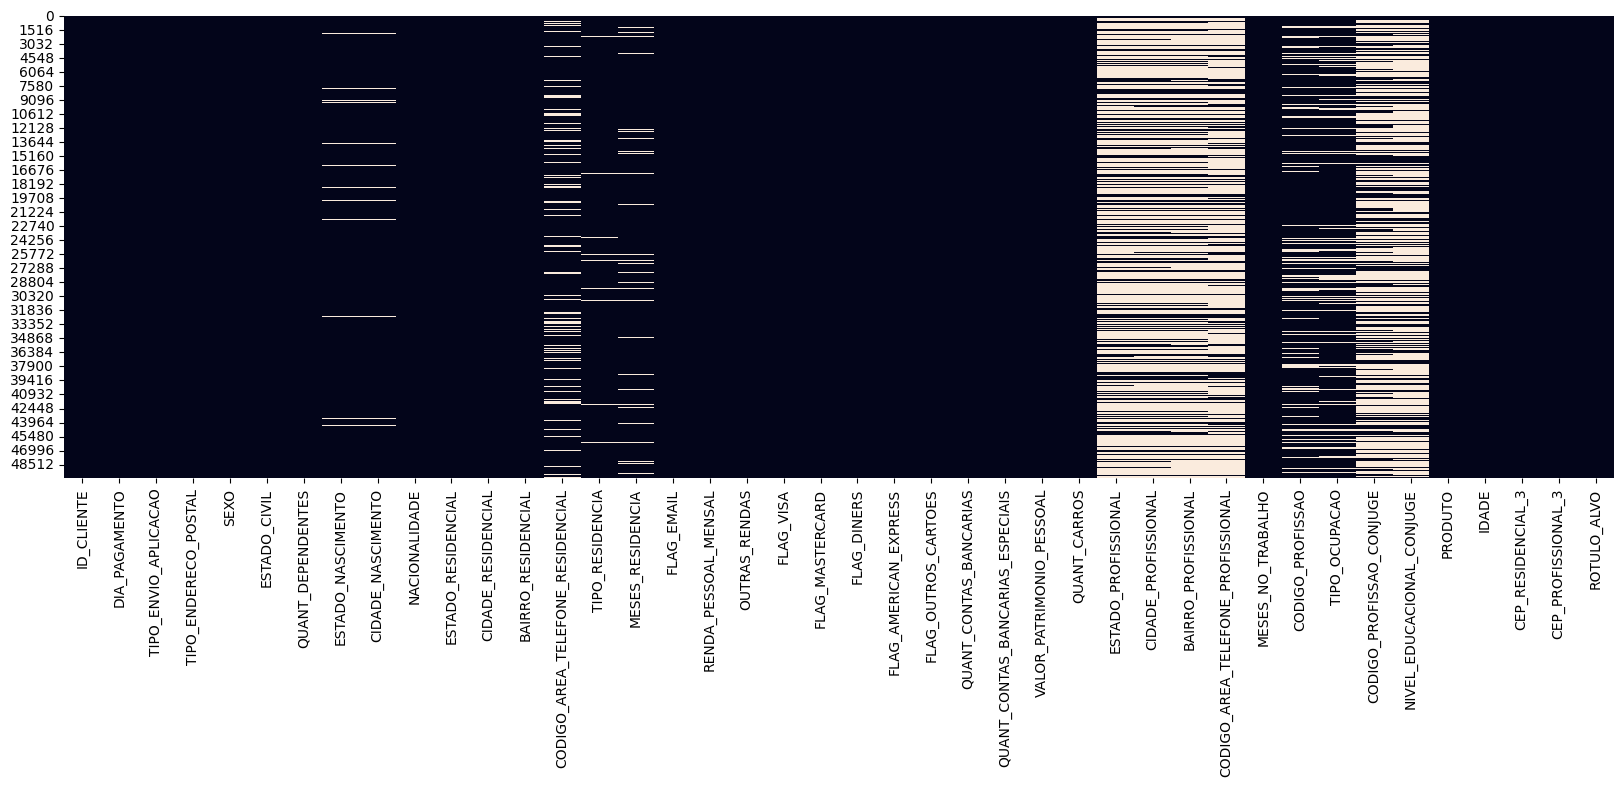

In [30]:
plt.figure(figsize=(20,6))
sns.heatmap(df_features_selects.isnull(), cbar=False)
plt.show()

**Insights**
- As variáveis 'ESTADO_PROFISSIONAL', 'CIDADE_PROFISSIONAL', 'BAIRRO_PROFISSIONAL', 'CODIGO_AREA_TELEFONE_PROFISSIONAL', 'CODIGO_PROFISSAO_CONJUGE' e 'NIVEL_EDUCACIONAL_CONJUGE' quantidade de nulos maior 50%, o que pode ser um alerta para o modelo. Entretanto, nesse momento ainda vale explorar um pouco mais.

## 3.3 Relacionamento com a Variável-Alvo

### 3.3.1 Dados Boolean

In [31]:
df_features_selects[feat_boolean + ['ROTULO_ALVO']]

,FLAG_VISA,FLAG_MASTERCARD,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_OUTROS_CARTOES,FLAG_EMAIL,ROTULO_ALVO
0,True,True,False,False,False,True,1
1,False,False,False,False,False,True,1
2,False,False,False,False,False,True,0
3,False,False,False,False,False,True,0
4,False,False,False,False,False,True,1
...,...,...,...,...,...,...,...
49995,False,False,False,False,False,True,1
49996,False,False,False,False,False,True,0
49997,False,False,False,False,False,True,0
49998,False,False,False,False,False,True,1


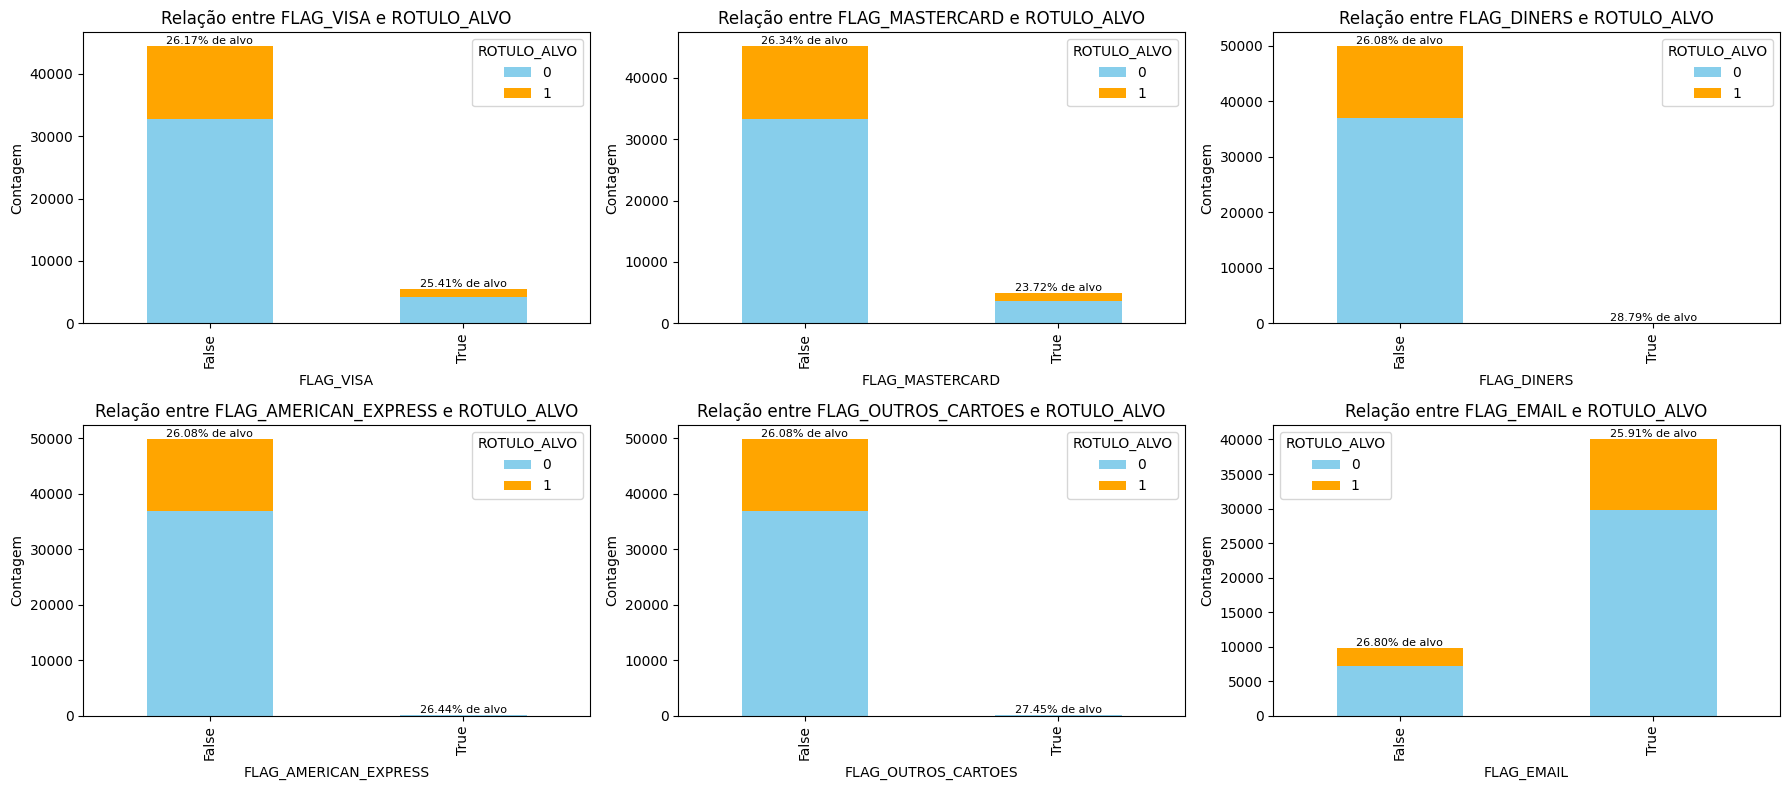

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

# Loop para criar os gráficos
for idx, flag in enumerate(feat_boolean):
    row, col = divmod(idx, 3)  # Calcula a linha e a coluna
    plot_relation_variableXtarget(df_features, flag, 'ROTULO_ALVO', ax=axes[row, col])

plt.tight_layout()
plt.show()

### 3.3.2 Dados Categoricos Nominal

In [33]:
feat_cateNominal_viz = df_features_selects[feat_cateNominal + ['ROTULO_ALVO']].copy()
for variable in feat_cateNominal:
    agrupar_top_5(feat_cateNominal_viz, variable)

feat_cateNominal_viz


,TIPO_ENVIO_APLICACAO,SEXO,ESTADO_NASCIMENTO,CIDADE_NASCIMENTO,ESTADO_RESIDENCIAL,CIDADE_RESIDENCIAL,BAIRRO_RESIDENCIAL,ESTADO_PROFISSIONAL,CIDADE_PROFISSIONAL,BAIRRO_PROFISSIONAL,CODIGO_PROFISSAO,TIPO_OCUPACAO,CODIGO_PROFISSAO_CONJUGE,PRODUTO,CEP_RESIDENCIAL_3,CEP_PROFISSIONAL_3,ESTADO_CIVIL,CODIGO_AREA_TELEFONE_RESIDENCIAL,TIPO_RESIDENCIA,CODIGO_AREA_TELEFONE_PROFISSIONAL,ROTULO_ALVO
0,Web,F,OUTROS,OUTROS,OUTROS,OUTROS,Centro,OUTROS,OUTROS,OUTROS,9.0,4.0,OUTROS,1,OUTROS,OUTROS,6,105,1.0,OUTROS,1
1,Carga,F,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,11.0,4.0,11.0,1,OUTROS,OUTROS,2,OUTROS,1.0,OUTROS,1
2,Web,F,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,11.0,OUTROS,OUTROS,1,591,591,2,105,1.0,OUTROS,0
3,Web,F,PE,OUTROS,PE,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,1,OUTROS,OUTROS,2,OUTROS,OUTROS,OUTROS,0
4,Web,M,OUTROS,RIO DE JANEIRO,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,9.0,5.0,OUTROS,1,OUTROS,OUTROS,2,OUTROS,1.0,OUTROS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,F,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,9.0,4.0,0.0,1,591,591,1,105,1.0,OUTROS,1
49996,0,F,SP,OUTROS,SP,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,OUTROS,2,OUTROS,OUTROS,1,OUTROS,1.0,OUTROS,0
49997,Web,M,OUTROS,OUTROS,SP,OUTROS,OUTROS,SP,OUTROS,OUTROS,9.0,2.0,OUTROS,1,OUTROS,OUTROS,2,5,2.0,5,0
49998,Web,F,SP,SAO PAULO,OUTROS,OUTROS,OUTROS,MG,OUTROS,OUTROS,9.0,2.0,OUTROS,1,OUTROS,OUTROS,1,OUTROS,1.0,OUTROS,1


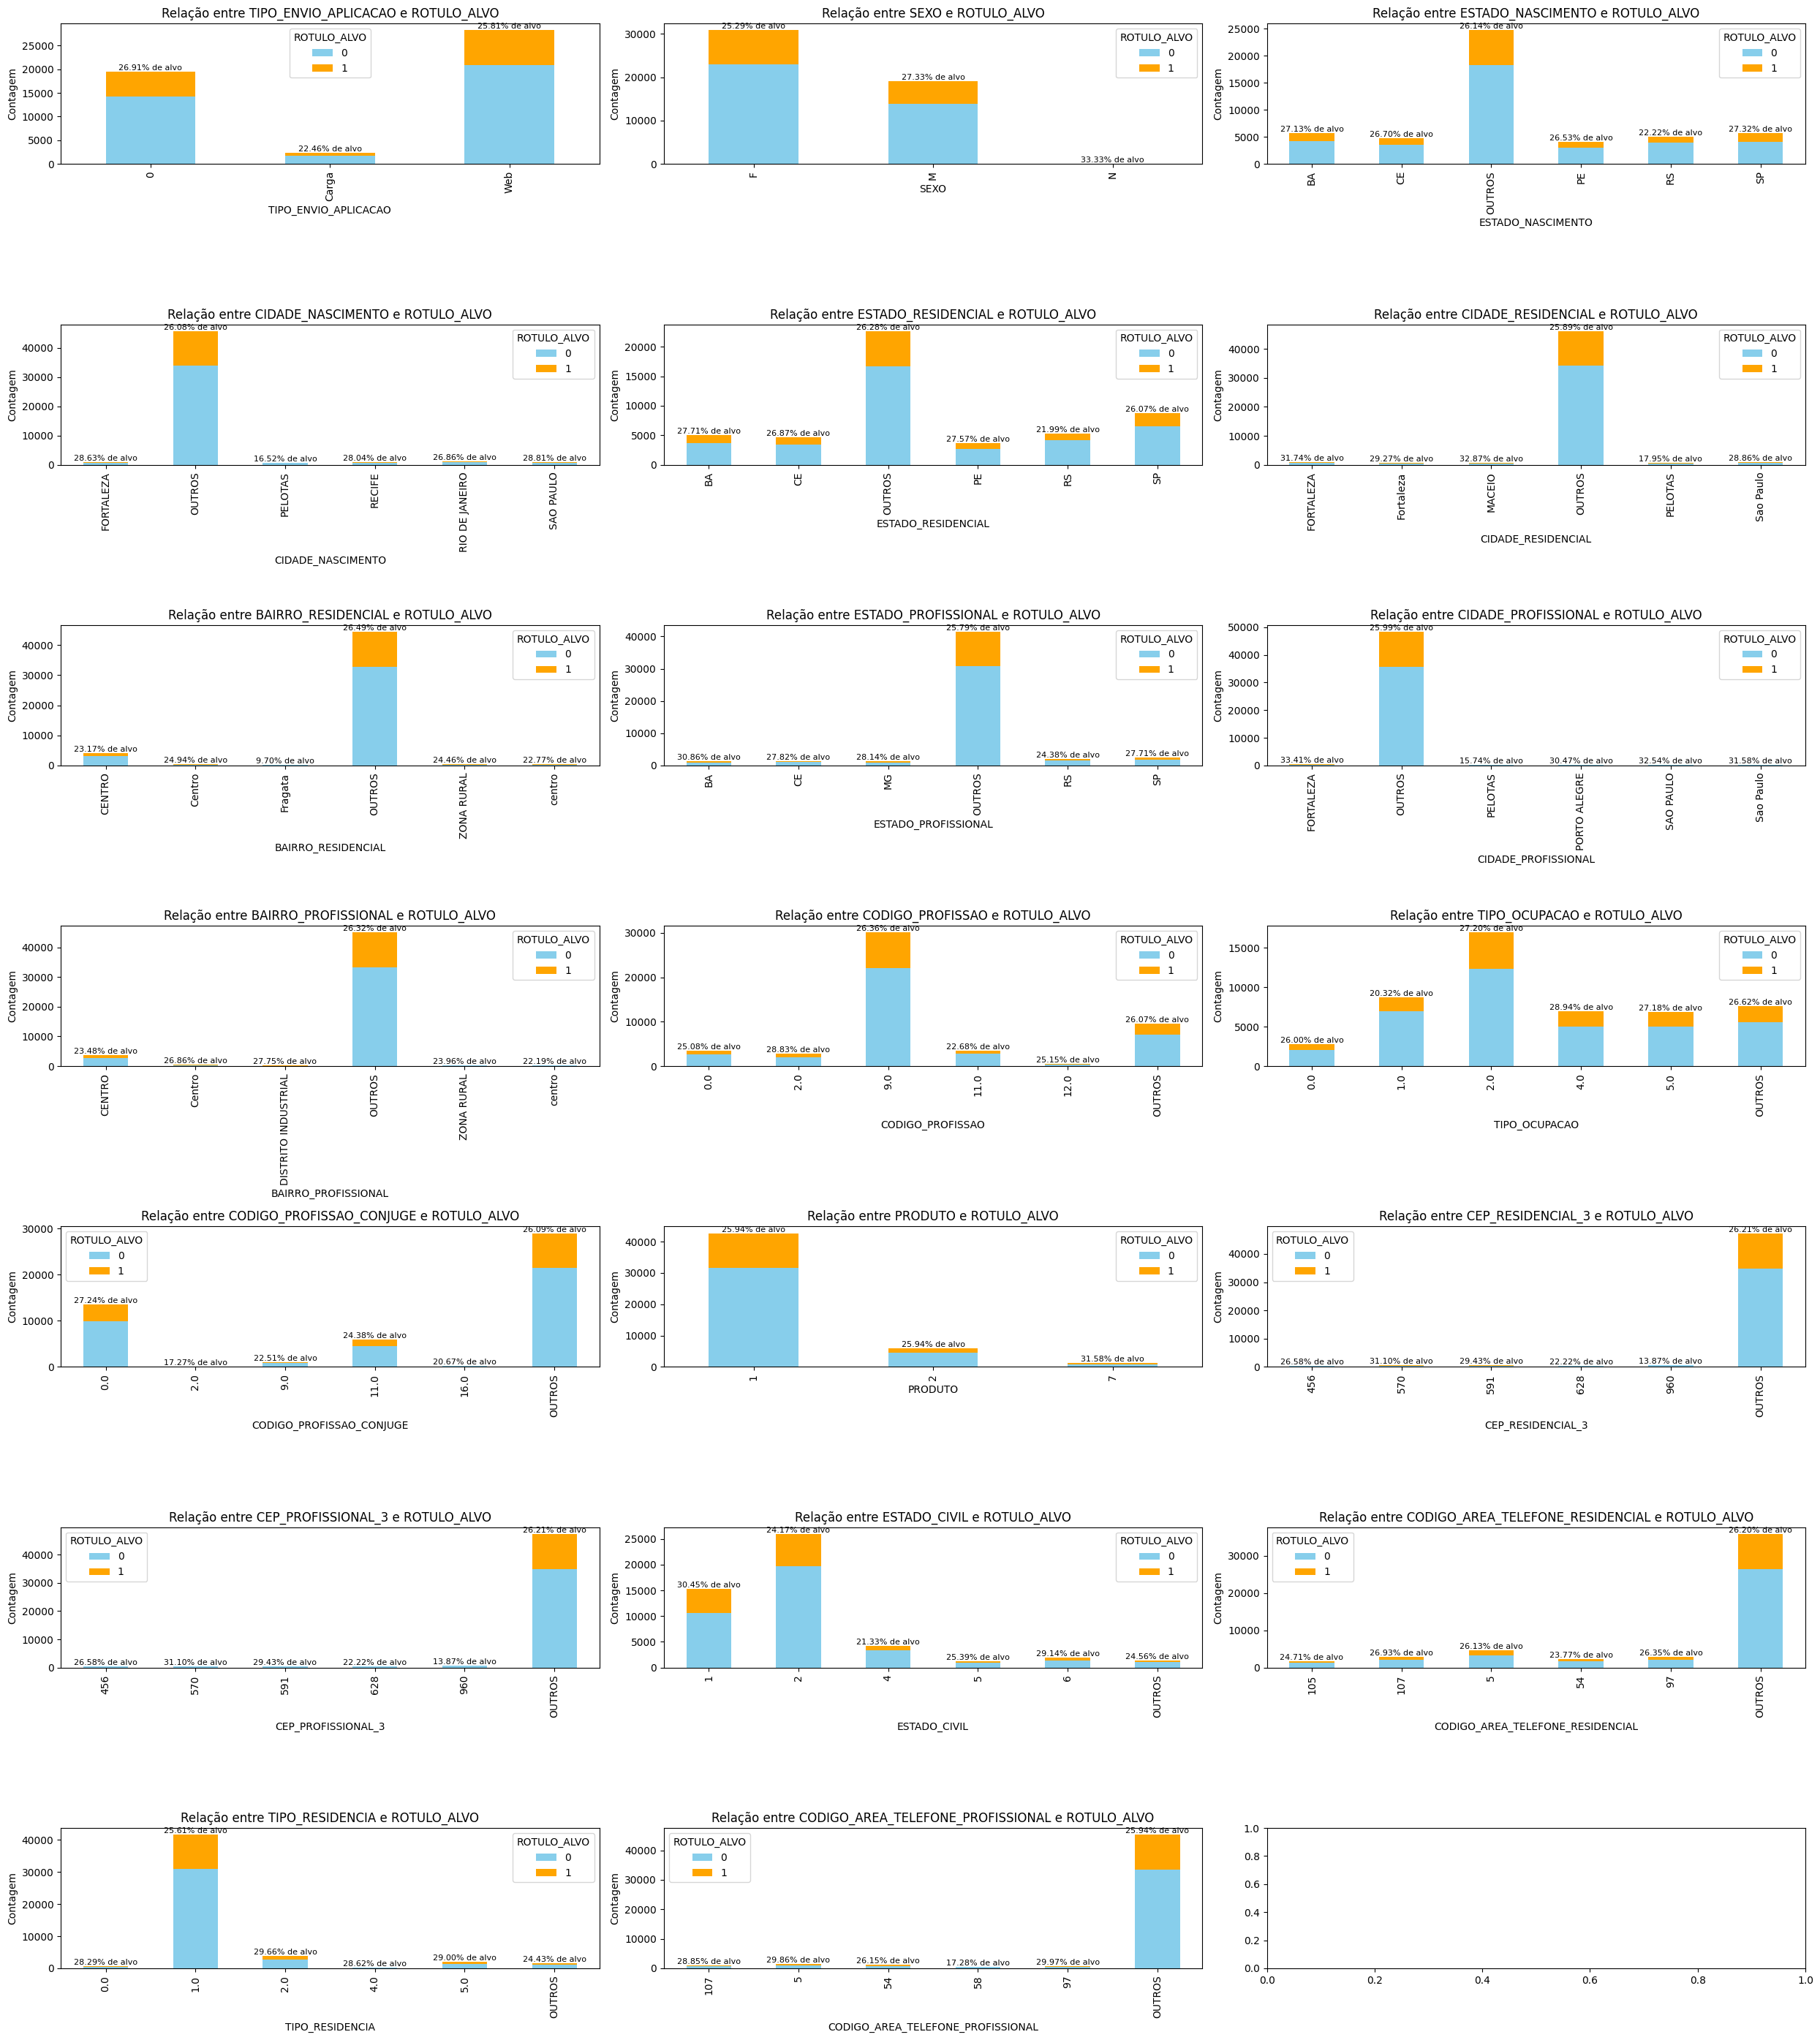

In [34]:
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(25, 28))

# Loop para criar os gráficos
for idx, flag in enumerate(feat_cateNominal):
    row, col = divmod(idx, 3)  # Calcula a linha e a coluna
    plot_relation_variableXtarget(feat_cateNominal_viz, flag, 'ROTULO_ALVO', ax=axes[row, col])

plt.tight_layout()
plt.show()

### 3.3.3 Dados Categoricos Ordinais

In [35]:
feat_cateOrdinal_viz = df_features_selects[feat_cateOrdinal + ['ROTULO_ALVO']].copy()
for variable in feat_cateOrdinal:
    agrupar_top_10(feat_cateOrdinal_viz, variable)

feat_cateOrdinal_viz

NameError: name 'agrupar_top_10' is not defined

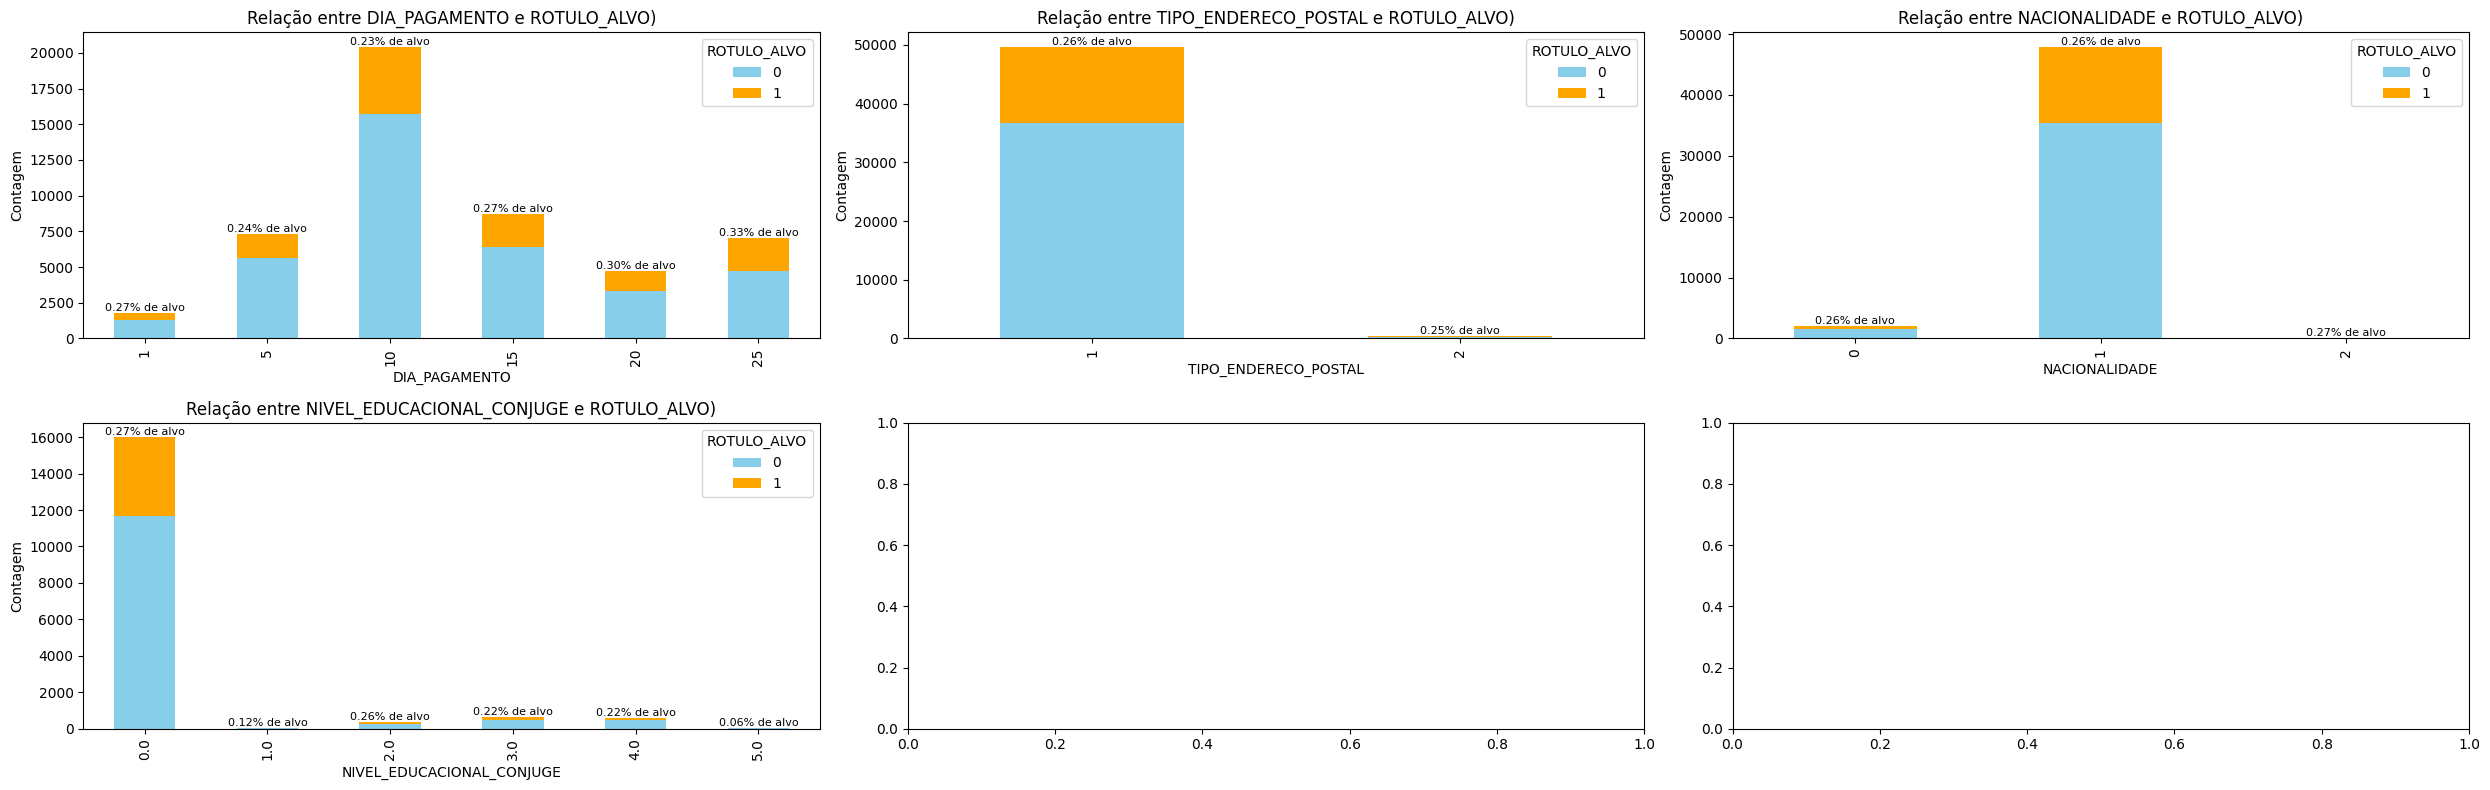

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 8))

# Loop para criar os gráficos
for idx, flag in enumerate(feat_cateOrdinal):
    row, col = divmod(idx, 3)  # Calcula a linha e a coluna
    plot_relation_variableXtarget(feat_cateOrdinal_viz, flag, 'ROTULO_ALVO', ax=axes[row, col])

plt.tight_layout()
plt.show()

### 3.3.4 Dados Numericos Continuos

In [ ]:
df_features_selects[feat_numeContinua + ['ROTULO_ALVO']]

,RENDA_PESSOAL_MENSAL,OUTRAS_RENDAS,VALOR_PATRIMONIO_PESSOAL,ROTULO_ALVO
0,900.00,0.0,0.0,1
1,750.00,0.0,0.0,1
2,500.00,0.0,0.0,0
3,500.00,0.0,0.0,0
4,1200.00,0.0,0.0,1
...,...,...,...,...
49995,1451.00,0.0,0.0,1
49996,450.00,0.0,0.0,0
49997,1555.00,0.0,0.0,0
49998,1443.27,0.0,0.0,1


In [ ]:
feat_numeContinua_viz = df_features_selects[feat_numeContinua + ['ROTULO_ALVO']]
feat_numeContinua_viz.corr()

,RENDA_PESSOAL_MENSAL,OUTRAS_RENDAS,VALOR_PATRIMONIO_PESSOAL,ROTULO_ALVO
RENDA_PESSOAL_MENSAL,1.000000,0.000032,0.008066,0.002819
OUTRAS_RENDAS,0.000032,1.000000,0.003353,0.004442
VALOR_PATRIMONIO_PESSOAL,0.008066,0.003353,1.000000,-0.003886
ROTULO_ALVO,0.002819,0.004442,-0.003886,1.000000


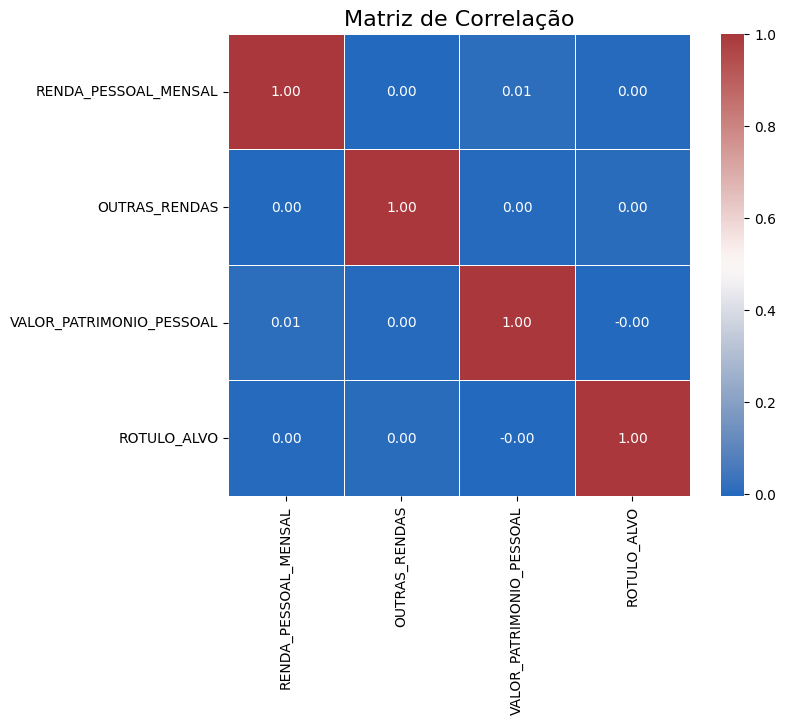

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(feat_numeContinua_viz.corr(), 
            annot=True,   
            cmap='vlag', 
            fmt=".2f",     
            square=True,  
            linewidths=0.5) 
plt.title("Matriz de Correlação", fontsize=16)
plt.show()

### 3.3.5 Dados Numericos Discretos

In [ ]:
df_features_selects[feat_numeDiscreta + ['ROTULO_ALVO']]

,QUANT_DEPENDENTES,MESES_RESIDENCIA,QUANT_CONTAS_BANCARIAS,QUANT_CONTAS_BANCARIAS_ESPECIAIS,QUANT_CARROS,MESES_NO_TRABALHO,IDADE,ROTULO_ALVO
0,1,15.0,0,0,0,0,32,1
1,0,1.0,0,0,0,0,34,1
2,0,NaN,0,0,0,0,27,0
3,0,NaN,0,0,0,0,61,0
4,0,12.0,0,0,0,0,48,1
...,...,...,...,...,...,...,...,...
49995,2,14.0,1,1,1,0,36,1
49996,0,15.0,0,0,0,0,21,0
49997,3,5.0,0,0,0,0,41,0
49998,1,NaN,0,0,0,0,28,1


In [ ]:
feat_numeDiscreta_viz = df_features_selects[feat_numeDiscreta + ['ROTULO_ALVO']]
feat_numeDiscreta_viz.corr()

,QUANT_DEPENDENTES,MESES_RESIDENCIA,QUANT_CONTAS_BANCARIAS,QUANT_CONTAS_BANCARIAS_ESPECIAIS,QUANT_CARROS,MESES_NO_TRABALHO,IDADE,ROTULO_ALVO
QUANT_DEPENDENTES,1.000000,-0.039378,0.028553,0.028553,0.025209,0.007597,-0.037415,0.012157
MESES_RESIDENCIA,-0.039378,1.000000,-0.047005,-0.047005,-0.043472,0.014715,0.223815,-0.029336
QUANT_CONTAS_BANCARIAS,0.028553,-0.047005,1.000000,1.000000,0.860860,-0.008341,0.024150,0.011997
QUANT_CONTAS_BANCARIAS_ESPECIAIS,0.028553,-0.047005,1.000000,1.000000,0.860860,-0.008341,0.024150,0.011997
QUANT_CARROS,0.025209,-0.043472,0.860860,0.860860,1.000000,-0.006033,0.019451,0.011706
MESES_NO_TRABALHO,0.007597,0.014715,-0.008341,-0.008341,-0.006033,1.000000,0.009908,-0.007073
IDADE,-0.037415,0.223815,0.024150,0.024150,0.019451,0.009908,1.000000,-0.107886
ROTULO_ALVO,0.012157,-0.029336,0.011997,0.011997,0.011706,-0.007073,-0.107886,1.000000


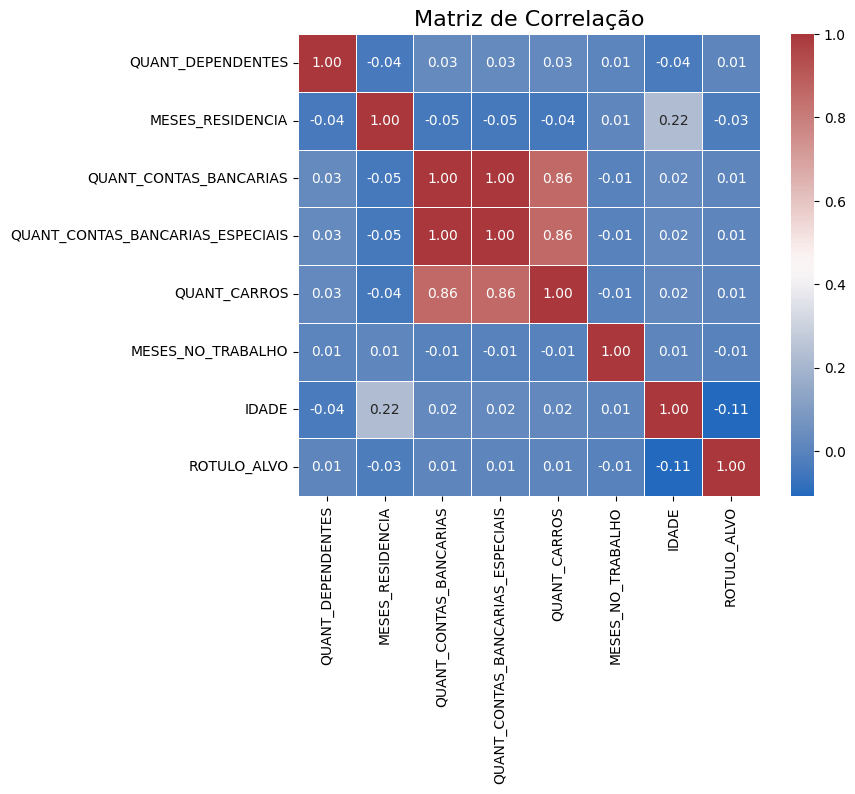

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(feat_numeDiscreta_viz.corr(), 
            annot=True,   
            cmap='vlag', 
            fmt=".2f",     
            square=True,  
            linewidths=0.5) 
plt.title("Matriz de Correlação", fontsize=16)
plt.show()

# 4. Respondendo e aprofundando nas Questões

## 4.1 Questão 1

Como as features sexo, estado civil, quantidade de dependentes e nível educacional está relacionada com a variável meta?

### 4.1.1 Sexo

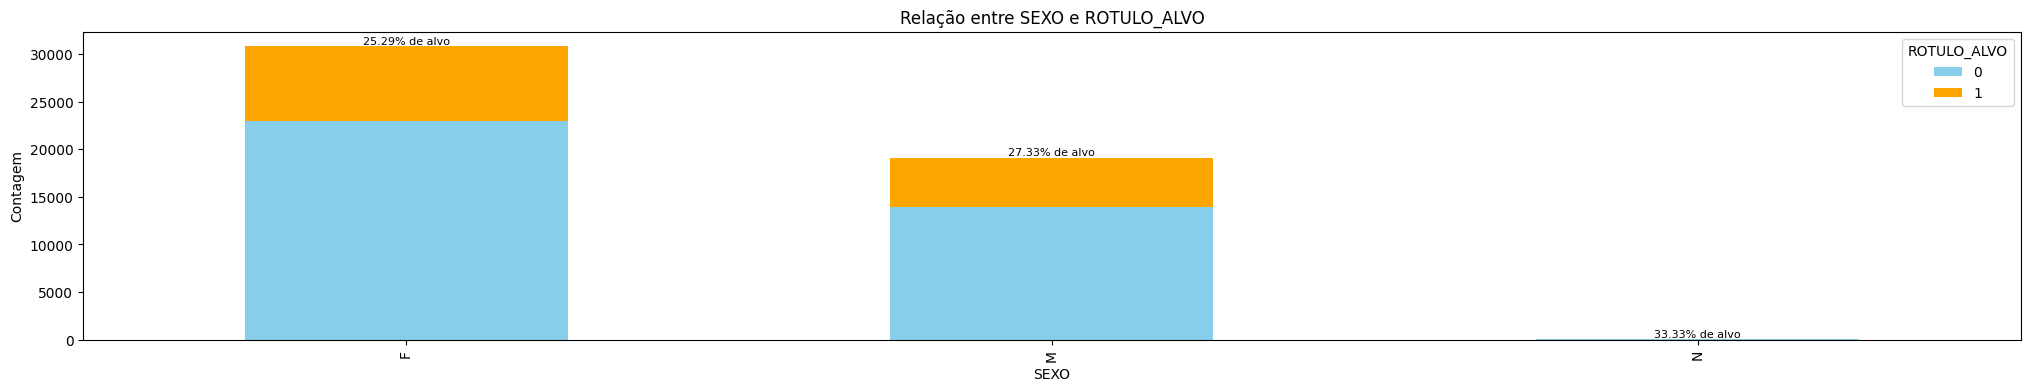

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25, 4))
plot_relation_variableXtarget(df_features, 'SEXO', 'ROTULO_ALVO')

In [ ]:
overview = df_features.groupby('SEXO').agg({
    'ID_CLIENTE': 'count',
    'ROTULO_ALVO': 'sum'
})

overview['TAXA_ALVO'] = overview['ROTULO_ALVO'] / overview['ID_CLIENTE']
overview['SHARE_PUBLICO'] = overview['ID_CLIENTE'] / 50000
overview['SHARE_TAXA_ALVO'] = overview['ROTULO_ALVO'] / 13034
overview

,ID_CLIENTE,ROTULO_ALVO,TAXA_ALVO,SHARE_PUBLICO,SHARE_TAXA_ALVO
SEXO,,,,,
F,30805,7790,0.252881,0.61610,0.597668
M,19130,5228,0.273288,0.38260,0.401105
N,48,16,0.333333,0.00096,0.001228


### 4.1.2 Estado Civil

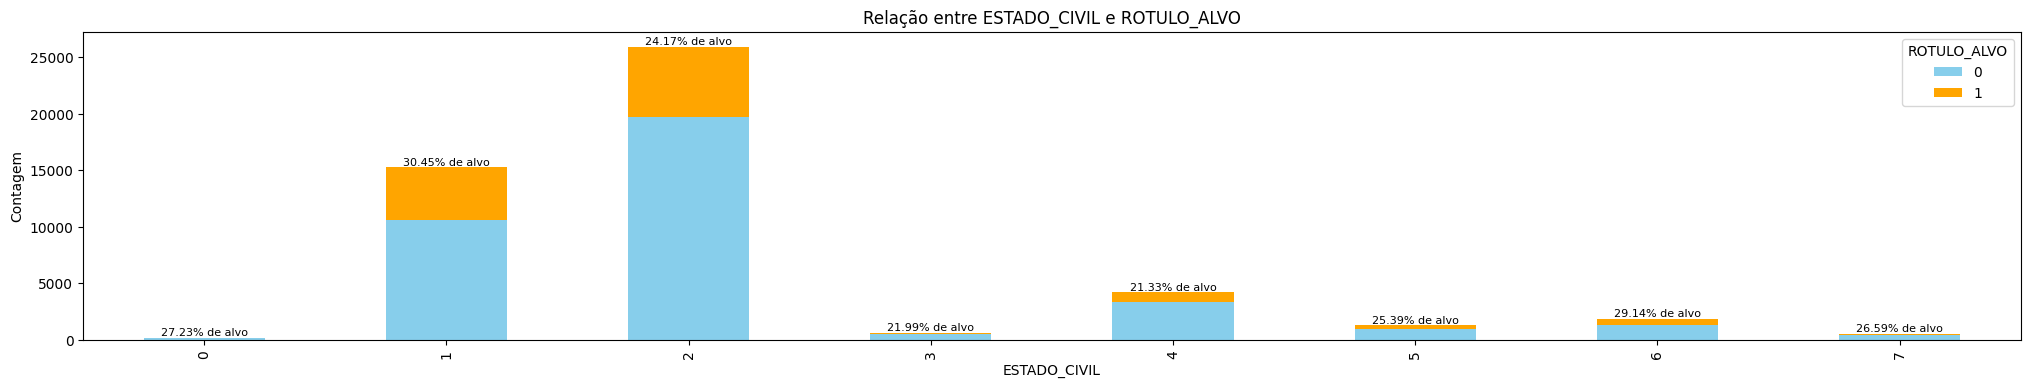

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25, 4))
plot_relation_variableXtarget(df_features, 'ESTADO_CIVIL', 'ROTULO_ALVO')

In [ ]:
overview = df_features.groupby('ESTADO_CIVIL').agg({
    'ID_CLIENTE': 'count',
    'ROTULO_ALVO': 'sum'
})

overview['TAXA_ALVO'] = overview['ROTULO_ALVO'] / overview['ID_CLIENTE']
overview['SHARE_PUBLICO'] = overview['ID_CLIENTE'] / 50000
overview['SHARE_TAXA_ALVO'] = overview['ROTULO_ALVO'] / 13034
overview

,ID_CLIENTE,ROTULO_ALVO,TAXA_ALVO,SHARE_PUBLICO,SHARE_TAXA_ALVO
ESTADO_CIVIL,,,,,
0,202,55,0.272277,0.00404,0.004220
1,15286,4655,0.304527,0.30572,0.357143
2,25967,6277,0.241730,0.51934,0.481587
3,632,139,0.219937,0.01264,0.010664
4,4206,897,0.213267,0.08412,0.068820
5,1296,329,0.253858,0.02592,0.025242
6,1877,547,0.291422,0.03754,0.041967
7,534,142,0.265918,0.01068,0.010895


### 4.1.3 Quantidade de Dependentes

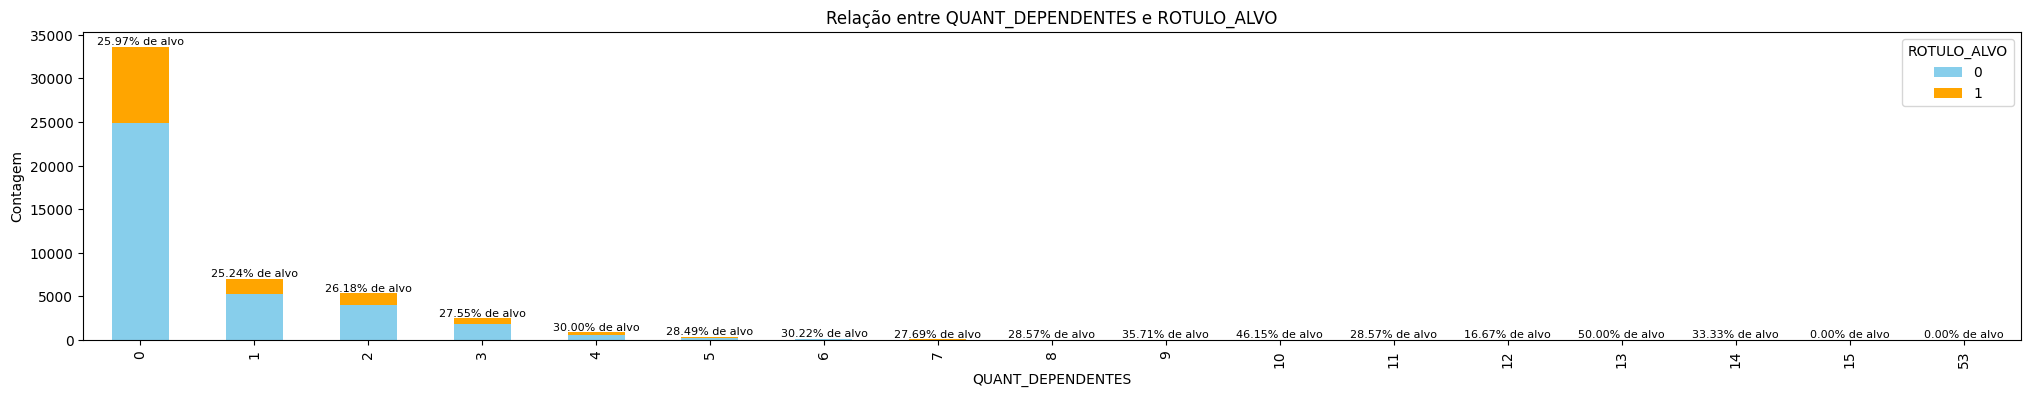

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25, 4))
plot_relation_variableXtarget(df_features, 'QUANT_DEPENDENTES', 'ROTULO_ALVO')


In [ ]:
overview = df_features.groupby('QUANT_DEPENDENTES').agg({
    'ID_CLIENTE': 'count',
    'ROTULO_ALVO': 'sum'
})

overview['TAXA_ALVO'] = overview['ROTULO_ALVO'] / overview['ID_CLIENTE']
overview['SHARE_PUBLICO'] = overview['ID_CLIENTE'] / 50000
overview['SHARE_TAXA_ALVO'] = overview['ROTULO_ALVO'] / 13034
overview

,ID_CLIENTE,ROTULO_ALVO,TAXA_ALVO,SHARE_PUBLICO,SHARE_TAXA_ALVO
QUANT_DEPENDENTES,,,,,
0,33655,8741,0.259724,0.67310,0.670631
1,7004,1768,0.252427,0.14008,0.135645
2,5363,1404,0.261794,0.10726,0.107718
3,2465,679,0.275456,0.04930,0.052095
4,860,258,0.300000,0.01720,0.019794
5,365,104,0.284932,0.00730,0.007979
6,139,42,0.302158,0.00278,0.003222
7,65,18,0.276923,0.00130,0.001381
8,35,10,0.285714,0.00070,0.000767


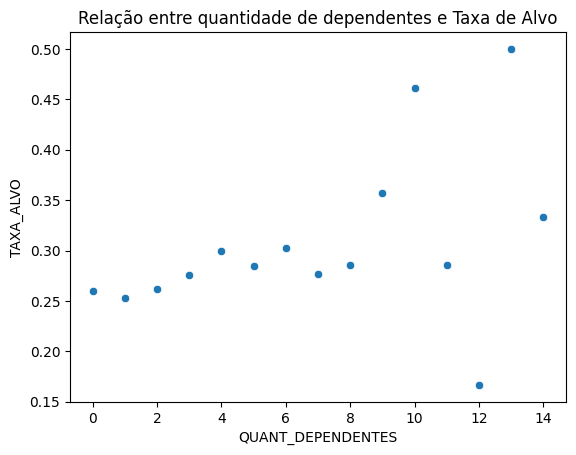

In [ ]:
overview_viz = overview[overview['ID_CLIENTE'] > 1]
sns.scatterplot(data=overview_viz, x='QUANT_DEPENDENTES', y='TAXA_ALVO',)
plt.title("Relação entre quantidade de dependentes e Taxa de Alvo")
plt.xlabel("QUANT_DEPENDENTES")
plt.ylabel("TAXA_ALVO")
plt.show()

### 4.1.4 Nivel Educacional

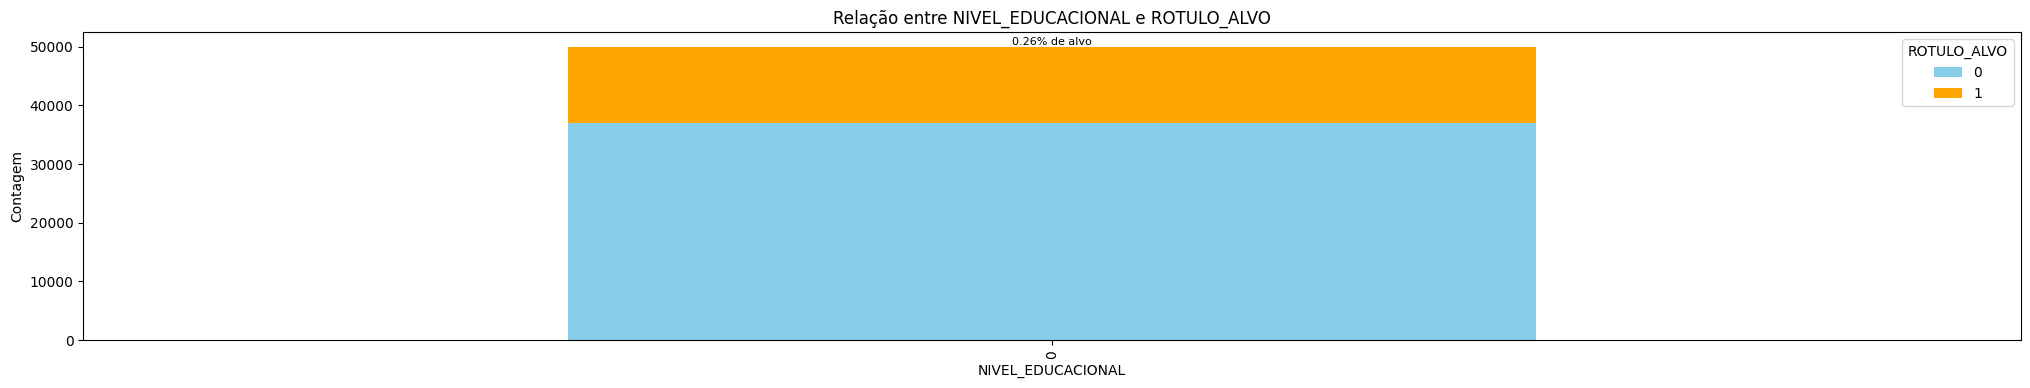

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25, 4))
plot_relation_variableXtarget(df_features, 'NIVEL_EDUCACIONAL', 'ROTULO_ALVO')

In [ ]:
overview = df_features.groupby('NIVEL_EDUCACIONAL').agg({
    'ID_CLIENTE': 'count',
    'ROTULO_ALVO': 'sum'
})

overview['TAXA_ALVO'] = overview['ROTULO_ALVO'] / overview['ID_CLIENTE']
overview['SHARE_PUBLICO'] = overview['ID_CLIENTE'] / 50000
overview['SHARE_TAXA_ALVO'] = overview['ROTULO_ALVO'] / 13034
overview

,ID_CLIENTE,ROTULO_ALVO,TAXA_ALVO,SHARE_PUBLICO,SHARE_TAXA_ALVO
NIVEL_EDUCACIONAL,,,,,
0,50000,13041,0.26082,1.0,1.000537


### 4.1.5 Insights Questão 1
- Mulheres apresentam uma taxa de alvo 2,03 p.p. superior à dos homens, indicando uma possível tendência desse grupo a apresentar maior inadimplência. Usuários sem informação de gênero demonstram uma taxa ainda maior (8,04 p.p.), porém o volume total desse grupo é extremamente pequeno, representando apenas 0,00096% do total.
- Embora o significado exato dos status não esteja claro, o Status 1 apresenta a maior taxa de alvo, indicando que pode representar o grupo com pior desempenho em relação a pagamentos. Por outro lado, o Status 2, que possui o maior share de público, apresenta uma taxa de alvo abaixo da média. Já a menor taxa de inadimplência está associada ao público do Status 4, com 21,33%.
- Em relação à Quantidade de Dependentes, observa-se uma leve tendência de aumento na taxa de alvo conforme cresce o número de dependentes, sugerindo que indivíduos com mais dependentes podem enfrentar maiores dificuldades para realizar os pagamentos.
- Por fim, a análise do Nível Educacional revelou que todos os usuários possuem a mesma informação, igual a 0, o que pode indicar um erro na coluna ou a representatividade de um grupo específico de usuários com o mesmo nível educacional.

## 4.2 Questão 2
Plote um gráfico que mostre a distribuição de bons e maus pagadores por estado. Escolha o gráfico que achar mais conveniente

In [ ]:
overview = df_features.groupby('ESTADO_RESIDENCIAL').agg({
    'ID_CLIENTE': 'count',
    'ROTULO_ALVO': 'sum'
})

overview['TAXA_ALVO'] = overview['ROTULO_ALVO'] / overview['ID_CLIENTE']
overview['SHARE_PUBLICO'] = overview['ID_CLIENTE'] / 50000
overview['SHARE_TAXA_ALVO'] = overview['ROTULO_ALVO'] / 13034
overview.reset_index(inplace=True)

overview

,ESTADO_RESIDENCIAL,ID_CLIENTE,ROTULO_ALVO,TAXA_ALVO,SHARE_PUBLICO,SHARE_TAXA_ALVO
0,AC,227,66,0.290749,0.00454,0.005064
1,AL,1467,447,0.304703,0.02934,0.034295
2,AM,402,122,0.303483,0.00804,0.009360
3,AP,493,117,0.237323,0.00986,0.008977
4,BA,4991,1383,0.277099,0.09982,0.106107
5,CE,4619,1241,0.268673,0.09238,0.095213
6,DF,700,216,0.308571,0.01400,0.016572
7,ES,688,193,0.280523,0.01376,0.014807
8,GO,1694,459,0.270956,0.03388,0.035216
9,MA,761,194,0.254928,0.01522,0.014884


In [ ]:
mapa_br = overview[['ESTADO_RESIDENCIAL', 'TAXA_ALVO']].copy()
mapa_br['TAXA_ALVO'] = mapa_br['TAXA_ALVO']*100

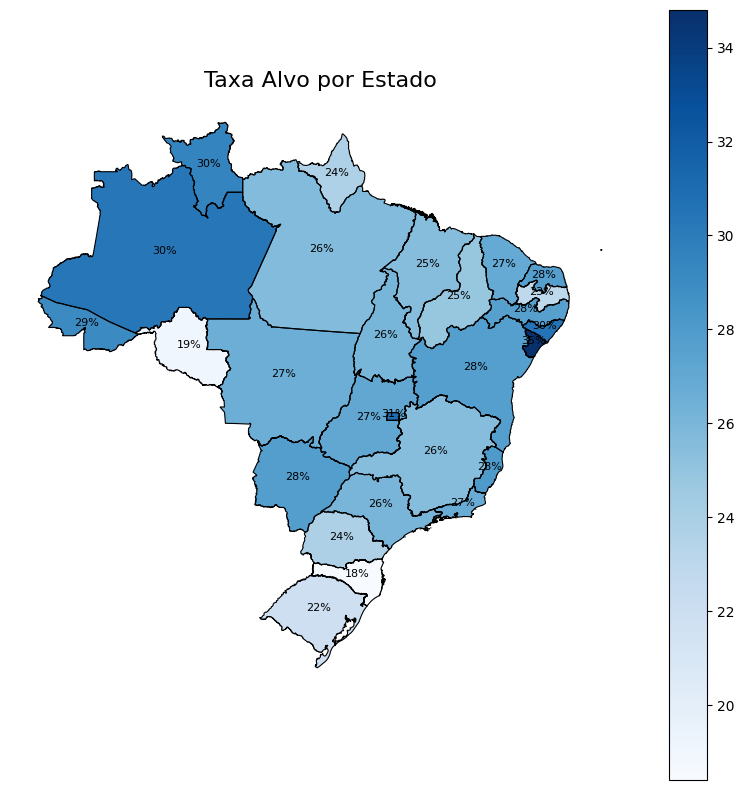

In [ ]:
# Carregar o shapefile do Brasil com os estados
brasil = gpd.read_file("https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson")

# Mapeamento de códigos de estados para o shapefile
brasil['ESTADO_RESIDENCIAL'] = brasil['sigla']  # O GeoJSON usado tem as ESTADO_RESIDENCIALs em uma coluna chamada 'id'

# Mesclar os dados do DataFrame com o GeoDataFrame
brasil_merged = brasil.merge(mapa_br, on='ESTADO_RESIDENCIAL', how='left')

# Plotar o mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
brasil_merged.boundary.plot(ax=ax, linewidth=0.8, color="black")  # Desenhar limites
brasil_merged.plot(
    column='TAXA_ALVO',
    ax=ax,
    legend=True,
    cmap='Blues',  # Alterne o cmap conforme necessário (ex: 'Blues', 'Reds')
    missing_kwds={"color": "lightgrey", "label": "Sem Dados"}  # Para estados sem dados
)

for idx, row in brasil_merged.iterrows():
    # Coordenadas centrais do estado
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    # Adicionar o texto com o valor de TAXA_ALVO
    ax.text(x, y, f"{row['TAXA_ALVO']:.0f}%", fontsize=8, ha='center', color='black')


plt.title("Taxa Alvo por Estado", fontsize=16)
plt.axis("off")
plt.show()

### 4.2.1 Insights Questão 1
- Os estados com as maiores taxas de Alvo são Sergipe (34,7%), Distrito Federal (30,8%), Alagoas (30,4%) e Amapá (30,3%). Em geral, é possível observar taxas mais baixas no Sul do Brasil, enquanto a maioria das regiões apresenta taxas próximas à média nacional de 26%.

## 4.3 Questão 3
Use boxplot para explicar como o tipo de residência interfere na classificação do pagador

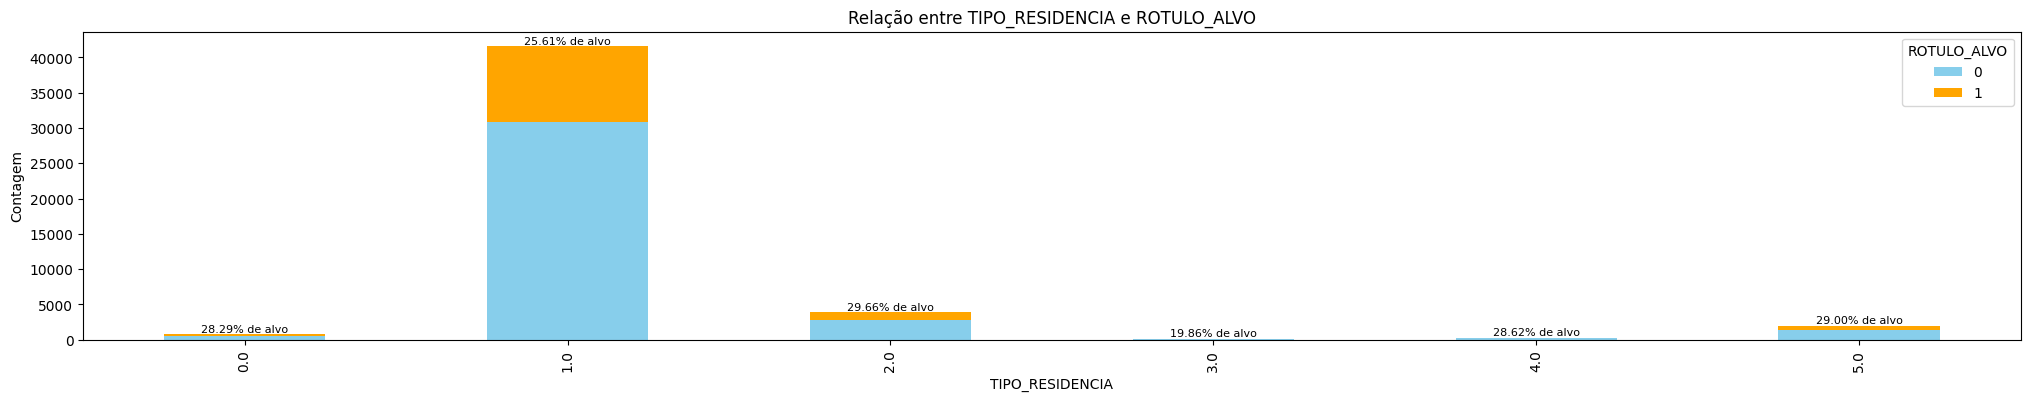

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25, 4))
plot_relation_variableXtarget(df_features, 'TIPO_RESIDENCIA', 'ROTULO_ALVO')


In [ ]:
overview = df_features.groupby('TIPO_RESIDENCIA').agg({
    'ID_CLIENTE': 'count',
    'ROTULO_ALVO': 'sum'
})

overview['TAXA_ALVO'] = overview['ROTULO_ALVO'] / overview['ID_CLIENTE']
overview['SHARE_PUBLICO'] = overview['ID_CLIENTE'] / 50000
overview['SHARE_TAXA_ALVO'] = overview['ROTULO_ALVO'] / 13034
overview.reset_index(inplace=True)

overview

,TIPO_RESIDENCIA,ID_CLIENTE,ROTULO_ALVO,TAXA_ALVO,SHARE_PUBLICO,SHARE_TAXA_ALVO
0,0.0,760,215,0.282895,0.01520,0.016495
1,1.0,41572,10646,0.256086,0.83144,0.816787
2,2.0,3884,1152,0.296601,0.07768,0.088384
3,3.0,141,28,0.198582,0.00282,0.002148
4,4.0,311,89,0.286174,0.00622,0.006828
5,5.0,1983,575,0.289965,0.03966,0.044115


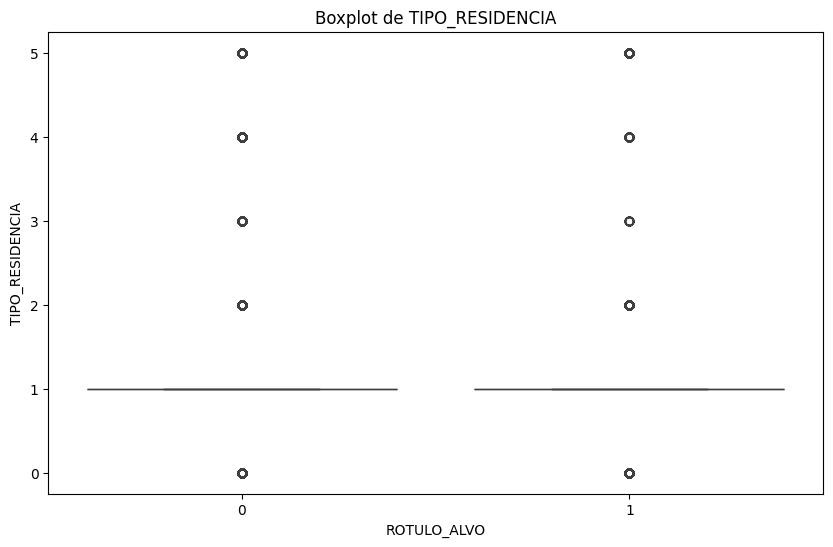

In [ ]:

# Criar o boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='ROTULO_ALVO', y='TIPO_RESIDENCIA', data=df_features)

# Adicionar título e rótulos aos eixos
plt.title('Boxplot de TIPO_RESIDENCIA')
plt.xlabel('ROTULO_ALVO')
plt.ylabel('TIPO_RESIDENCIA')

# Exibir o gráfico
plt.show()


### 4.3.1 Insights Questão 3
- Com o boxplot e as análises adicionais, observamos que, tanto para a Classificação 1 quanto para a Classificação 0, a maior concentração de dados está no valor "Tipo de Residência" igual a 1. Os outros valores de "Tipo de Residência" são considerados outliers, apresentando distribuições mais afastadas da tendência central.

## 4.4 Questão 4
Como as features renda pessoal mensal e outras rendas se relacionam com a variável meta? (obs: não é correlação estatística)

### 4.4.1 Exploração do Problema

In [ ]:
df_features_renda = df_features[['ID_CLIENTE','RENDA_PESSOAL_MENSAL','OUTRAS_RENDAS','ROTULO_ALVO']].copy()
df_features_renda

,ID_CLIENTE,RENDA_PESSOAL_MENSAL,OUTRAS_RENDAS,ROTULO_ALVO
0,1,900.00,0.0,1
1,2,750.00,0.0,1
2,3,500.00,0.0,0
3,4,500.00,0.0,0
4,5,1200.00,0.0,1
...,...,...,...,...
49995,49996,1451.00,0.0,1
49996,49997,450.00,0.0,0
49997,49998,1555.00,0.0,0
49998,49999,1443.27,0.0,1


In [ ]:
df_features[['RENDA_PESSOAL_MENSAL','OUTRAS_RENDAS','ROTULO_ALVO']].describe()

,RENDA_PESSOAL_MENSAL,OUTRAS_RENDAS,ROTULO_ALVO
count,50000.000000,50000.000000,50000.000000
mean,886.678437,35.434760,0.260820
std,7846.959327,891.515142,0.439086
min,60.000000,0.000000,0.000000
25%,360.000000,0.000000,0.000000
50%,500.000000,0.000000,0.000000
75%,800.000000,0.000000,1.000000
max,959000.000000,194344.000000,1.000000


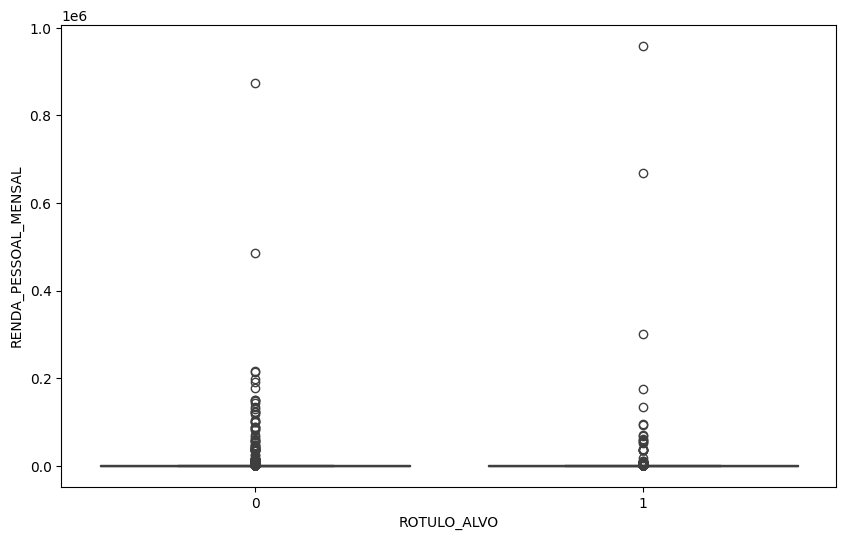

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_features, x='ROTULO_ALVO', y='RENDA_PESSOAL_MENSAL')
plt.show()

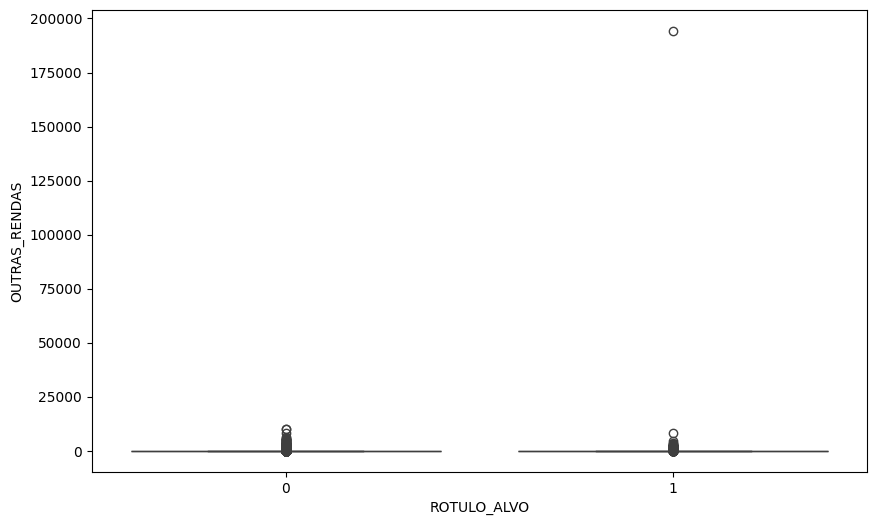

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_features, x='ROTULO_ALVO', y='OUTRAS_RENDAS')
plt.show()

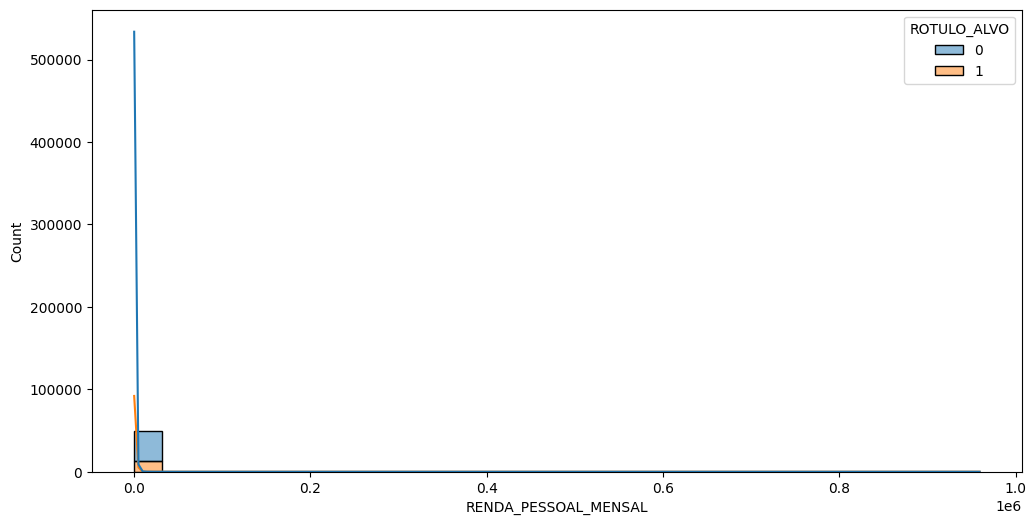

In [ ]:
plt.figure(figsize=(12, 6))

# Histograma para Renda Pessoal Mensal
sns.histplot(data=df_features, x='RENDA_PESSOAL_MENSAL', hue='ROTULO_ALVO', multiple='stack', kde=True, bins=30)
plt.show()

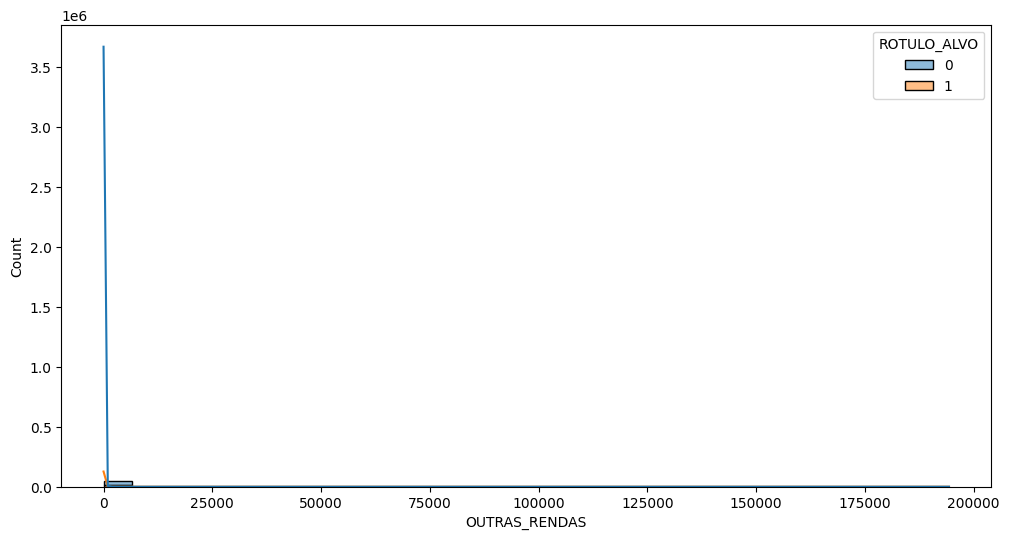

In [ ]:
plt.figure(figsize=(12, 6))

# Histograma para Renda Pessoal Mensal
sns.histplot(data=df_features, x='OUTRAS_RENDAS', hue='ROTULO_ALVO', multiple='stack', kde=True, bins=30)
plt.show()

### 4.4.2 Renda Pessoal Mensal

In [ ]:
# Calcular os quartis
q1 = df_features_renda['RENDA_PESSOAL_MENSAL'].quantile(0.25)
q2 = df_features_renda['RENDA_PESSOAL_MENSAL'].quantile(0.5) 
q3 = df_features_renda['RENDA_PESSOAL_MENSAL'].quantile(0.75)

df_features_renda['RENDA_PESSOAL_MENSAL_GROUP'] = pd.cut(df_features_renda['RENDA_PESSOAL_MENSAL'], bins=[-float('inf'), q1, q2, q3, float('inf')],
                           labels=['Baixo', 'Médio-baixo', 'Médio-alto', 'Alto'])
df_features_renda

,ID_CLIENTE,RENDA_PESSOAL_MENSAL,OUTRAS_RENDAS,ROTULO_ALVO,RENDA_PESSOAL_MENSAL_GROUP
0,1,900.00,0.0,1,Alto
1,2,750.00,0.0,1,Médio-alto
2,3,500.00,0.0,0,Médio-baixo
3,4,500.00,0.0,0,Médio-baixo
4,5,1200.00,0.0,1,Alto
...,...,...,...,...,...
49995,49996,1451.00,0.0,1,Alto
49996,49997,450.00,0.0,0,Médio-baixo
49997,49998,1555.00,0.0,0,Alto
49998,49999,1443.27,0.0,1,Alto


/var/folders/jg/ltscjj4d0cn9rp9tg94kl1kr0000gn/T/ipykernel_11903/1706253907.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = df.groupby([variable, target_column]).size().unstack(fill_value=0)


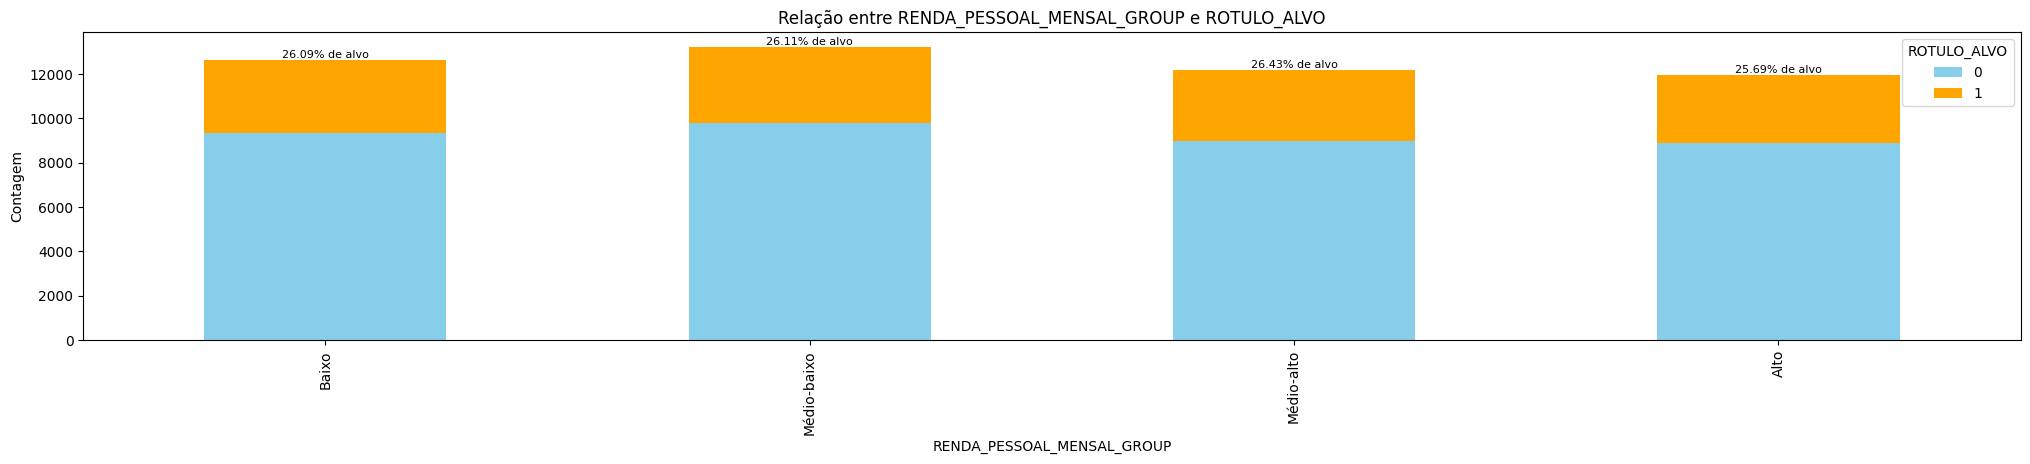

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25, 4))
plot_relation_variableXtarget(df_features_renda, 'RENDA_PESSOAL_MENSAL_GROUP', 'ROTULO_ALVO')

In [ ]:
overview = df_features_renda.groupby('RENDA_PESSOAL_MENSAL_GROUP').agg({
    'ID_CLIENTE': 'count',
    'ROTULO_ALVO': 'sum'
})

overview['TAXA_ALVO'] = overview['ROTULO_ALVO'] / overview['ID_CLIENTE']
overview['SHARE_PUBLICO'] = overview['ID_CLIENTE'] / 50000
overview['SHARE_TAXA_ALVO'] = overview['ROTULO_ALVO'] / 13034
overview.reset_index(inplace=True)

overview

/var/folders/jg/ltscjj4d0cn9rp9tg94kl1kr0000gn/T/ipykernel_11903/578282596.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  overview = df_features_renda.groupby('RENDA_PESSOAL_MENSAL_GROUP').agg({


,RENDA_PESSOAL_MENSAL_GROUP,ID_CLIENTE,ROTULO_ALVO,TAXA_ALVO,SHARE_PUBLICO,SHARE_TAXA_ALVO
0,Baixo,12646,3299,0.260873,0.25292,0.253107
1,Médio-baixo,13220,3452,0.261120,0.26440,0.264846
2,Médio-alto,12192,3222,0.264272,0.24384,0.247200
3,Alto,11942,3068,0.256908,0.23884,0.235384


### 4.4.3 Outras Rendas

In [ ]:
df_features_renda['OUTRAS_RENDAS_GROUP'] = df_features_renda['OUTRAS_RENDAS'].apply(lambda x: 'Sim' if x > 1 else 'Não')
df_features_renda


,ID_CLIENTE,RENDA_PESSOAL_MENSAL,OUTRAS_RENDAS,ROTULO_ALVO,RENDA_PESSOAL_MENSAL_GROUP,OUTRAS_RENDAS_GROUP
0,1,900.00,0.0,1,Alto,Não
1,2,750.00,0.0,1,Médio-alto,Não
2,3,500.00,0.0,0,Médio-baixo,Não
3,4,500.00,0.0,0,Médio-baixo,Não
4,5,1200.00,0.0,1,Alto,Não
...,...,...,...,...,...,...
49995,49996,1451.00,0.0,1,Alto,Não
49996,49997,450.00,0.0,0,Médio-baixo,Não
49997,49998,1555.00,0.0,0,Alto,Não
49998,49999,1443.27,0.0,1,Alto,Não


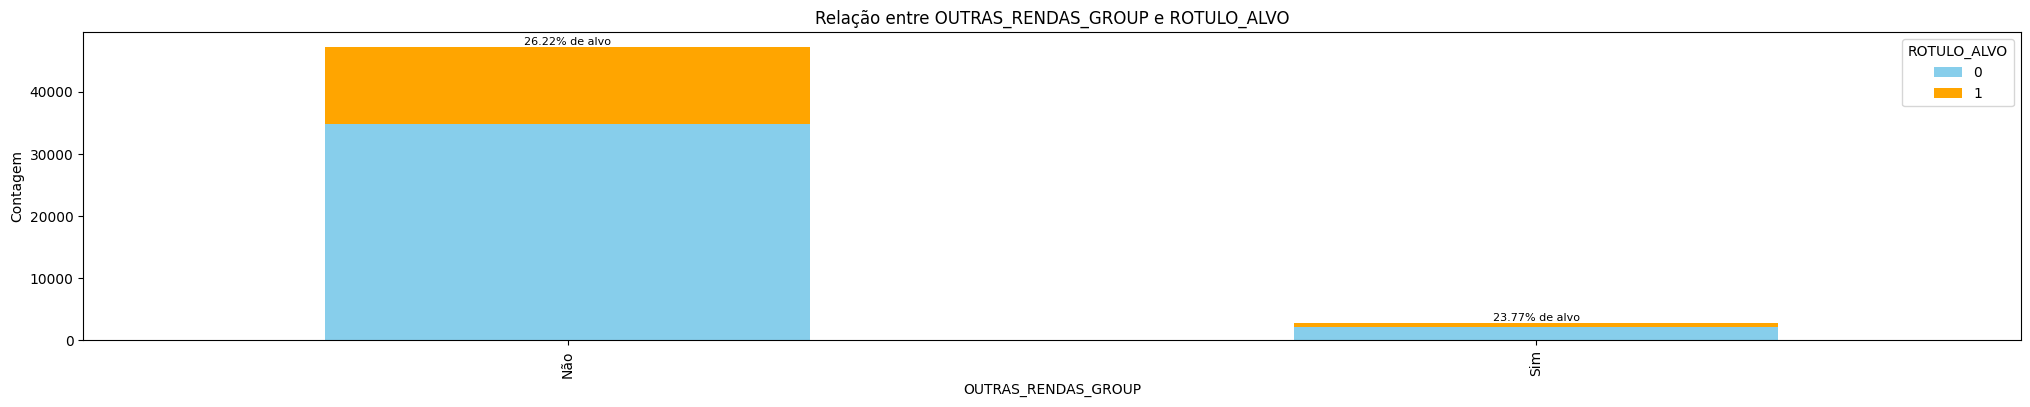

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25, 4))
plot_relation_variableXtarget(df_features_renda, 'OUTRAS_RENDAS_GROUP', 'ROTULO_ALVO')

### 4.4.4 Insights
- Após a análise exploratória, observamos que a variável "renda pessoal" apresenta alguns casos com valores extremamente altos, o que pode distorcer uma análise de correlação estatística. Além disso, a distribuição segue um padrão de cauda longa, com uma grande concentração de valores no canto esquerdo. Para compreender melhor a variável, decidimos classificá-la com base nos quartis e, assim, avaliar o comportamento de cada intervalo. Ao analisar os quartis, notamos que as taxas de alvo são bastante semelhantes entre eles, indicando que a "renda pessoal mensal" não tem um impacto significativo na definição do perfil de pagamento dos usuários.
- No caso de "outras rendas", a situação é semelhante à observada para "renda pessoal", mas com a diferença de que o volume de usuários com "outras rendas" é muito pequeno, o que inviabiliza a aplicação do mesmo método. Assim, optamos por comparar os usuários que possuem "outras rendas" com aqueles que não possuem. Os resultados mostraram que os usuários com "outras rendas" apresentaram uma taxa de alvo 2,44 p.p. menor, sugerindo que esse grupo tem um perfil de pagamento mais favorável.

## 4.5 Questão 5
A idade interfere na classificação do pagador?

In [ ]:
df_features

,ID_CLIENTE,TIPO_FUNCIONARIO,DIA_PAGAMENTO,TIPO_ENVIO_APLICACAO,QUANT_CARTOES_ADICIONAIS,TIPO_ENDERECO_POSTAL,SEXO,ESTADO_CIVIL,QUANT_DEPENDENTES,NIVEL_EDUCACIONAL,ESTADO_NASCIMENTO,CIDADE_NASCIMENTO,NACIONALIDADE,ESTADO_RESIDENCIAL,CIDADE_RESIDENCIAL,BAIRRO_RESIDENCIAL,FLAG_TELEFONE_RESIDENCIAL,CODIGO_AREA_TELEFONE_RESIDENCIAL,TIPO_RESIDENCIA,MESES_RESIDENCIA,FLAG_TELEFONE_MOVEL,FLAG_EMAIL,RENDA_PESSOAL_MENSAL,OUTRAS_RENDAS,FLAG_VISA,FLAG_MASTERCARD,FLAG_DINERS,FLAG_AMERICAN_EXPRESS,FLAG_OUTROS_CARTOES,QUANT_CONTAS_BANCARIAS,QUANT_CONTAS_BANCARIAS_ESPECIAIS,VALOR_PATRIMONIO_PESSOAL,QUANT_CARROS,EMPRESA,ESTADO_PROFISSIONAL,CIDADE_PROFISSIONAL,BAIRRO_PROFISSIONAL,FLAG_TELEFONE_PROFISSIONAL,CODIGO_AREA_TELEFONE_PROFISSIONAL,MESES_NO_TRABALHO,CODIGO_PROFISSAO,TIPO_OCUPACAO,CODIGO_PROFISSAO_CONJUGE,NIVEL_EDUCACIONAL_CONJUGE,FLAG_DOCUMENTO_RESIDENCIAL,FLAG_RG,FLAG_CPF,FLAG_COMPROVANTE_RENDA,PRODUTO,FLAG_REGISTRO_ACSP,IDADE,CEP_RESIDENCIAL_3,CEP_PROFISSIONAL_3,ROTULO_ALVO
0,1,C,5,Web,0,1,F,6,1,0,RN,Assu,1,RN,Santana do Matos,Centro,True,105,1.0,15.0,True,True,900.00,0.0,True,True,False,False,False,0,0,0.0,0,True,NaN,NaN,NaN,True,NaN,0,9.0,4.0,NaN,NaN,False,False,False,False,1,True,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,RJ,rio de janeiro,1,RJ,RIO DE JANEIRO,CAMPO GRANDE,True,20,1.0,1.0,True,True,750.00,0.0,False,False,False,False,False,0,0,0.0,0,True,NaN,NaN,NaN,True,NaN,0,11.0,4.0,11.0,NaN,False,False,False,False,1,True,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,RN,GARANHUNS,1,RN,Parnamirim,Boa Esperanca,True,105,1.0,NaN,True,True,500.00,0.0,False,False,False,False,False,0,0,0.0,0,True,NaN,NaN,NaN,True,NaN,0,11.0,NaN,NaN,NaN,False,False,False,False,1,True,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,PE,CABO,1,PE,CABO,PONTE DOS CARVALHOS,True,NaN,NaN,NaN,True,True,500.00,0.0,False,False,False,False,False,0,0,0.0,0,True,NaN,NaN,NaN,True,NaN,0,NaN,NaN,NaN,NaN,False,False,False,False,1,True,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,RJ,RIO DE JANEIRO,1,RJ,Rio de Janeiro,Santa Cruz,True,20,1.0,12.0,True,True,1200.00,0.0,False,False,False,False,False,0,0,0.0,0,True,NaN,NaN,NaN,True,NaN,0,9.0,5.0,NaN,NaN,False,False,False,False,1,True,48,235,235,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49996,C,10,0,0,1,F,1,2,0,RN,NATAL,1,RN,NATAL,PAJUCARA,True,105,1.0,14.0,True,True,1451.00,0.0,False,False,False,False,False,1,1,0.0,1,True,NaN,NaN,NaN,True,NaN,0,9.0,4.0,0.0,0.0,False,False,False,False,1,True,36,591,591,1
49996,49997,C,25,0,0,1,F,1,0,0,SP,LENCOIS PAULISTA,1,SP,Lencois Paulista,Nucleo Habitacional Joao Zillo,True,12,1.0,15.0,True,True,450.00,0.0,False,False,False,False,False,0,0,0.0,0,True,NaN,NaN,NaN,True,NaN,0,NaN,NaN,NaN,NaN,False,False,False,False,2,True,21,186,186,0
49997,49998,C,5,Web,0,1,M,2,3,0,PR,RIO BONITO,1,SP,GUARULHOS,jardim vida nova,True,5,2.0,5.0,True,True,1555.00,0.0,False,False,False,False,False,0,0,0.0,0,True,SP,GUARULHOS,ITAPEGICA,True,5,0,9.0,2.0,NaN,NaN,False,False,False,False,1,True,41,715,715,0
49998,49999,C,1,Web,0,1,F,1,1,0,SP,SAO PAULO,1,MG,CONTAGEM,VILA BELEM,True,29,1.0,NaN,True,True,1443.27,0.0,False,False,False,False,False,0,0,0.0,0,True,MG,BETIM,JARDIM ALTEROSA,True,29,0,9.0,2.0,NaN,NaN,False,False,False,False,1,True,28,320,320,1


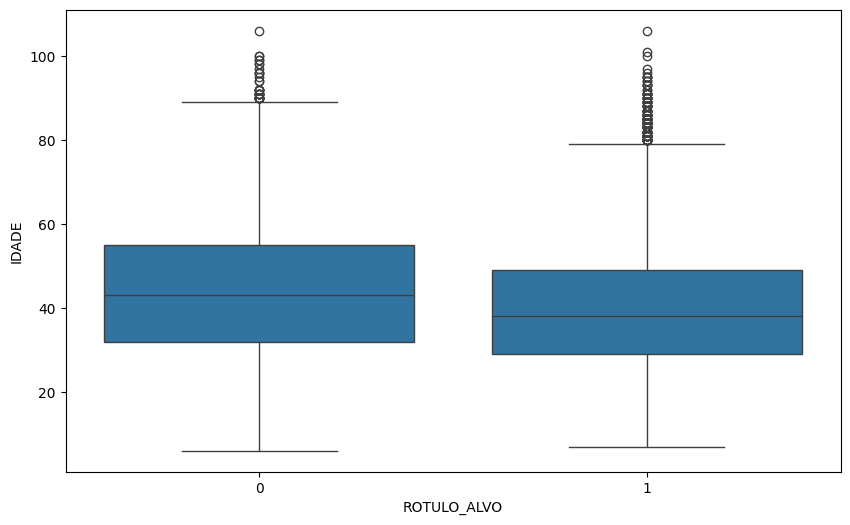

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_features, x='ROTULO_ALVO', y='IDADE')
plt.show()

In [ ]:
correlacao_pearson = df_features['ROTULO_ALVO'].corr(df_features['IDADE'])
correlacao_spearman = df_features['ROTULO_ALVO'].corr(df_features['IDADE'], method='spearman')
correlacao_kendall = df_features['ROTULO_ALVO'].corr(df_features['IDADE'], method='kendall')
correlacao_pointbiserialr, p_value = pointbiserialr(df_features['ROTULO_ALVO'], df_features['IDADE'])

print(f"Correlação de Pearson: {correlacao_pearson}")
print(f"Correlação de Spearman: {correlacao_spearman}")
print(f"Correlação de Kendall: {correlacao_kendall}")
print(f"Correlação de Pontos Biseriais: {correlacao_pointbiserialr}")

Correlação de Pearson: -0.10788644662199214
Correlação de Spearman: -0.11387222216062799
Correlação de Kendall: -0.09385359284155749
Correlação de Pontos Biseriais: -0.10788644662199215


### 4.5.1 Insights
- Ao analisar diversas correlações e um gráfico de boxplot, observamos que a variável "Idade" apresenta uma correlação negativa fraca com a variável alvo. Isso sugere que, embora a relação seja fraca, há uma leve tendência de que, à medida que os usuários envelhecem, a probabilidade de serem classificados como maus pagadores diminui.
- Essa correlação fraca indica que a idade pode ter algum efeito sobre o comportamento de pagamento dos usuários, mas não é um fator determinante.